# Projet 7 : Implémentez un modèle de scoring

Pour ce projet, nous nous plaçons en tant que Data Scientist au sein d'une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

les objectifs de ce projet sont:
-  développer un modèle de scoring de la probabilité de défaut de paiement d'un client pour étayer la décision d'accorder ou non un prêt à un client potentiel

- Créer un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Installation des librairies

In [ ]:
!pip install lightgbm==2.2.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.4.0
    Uninstalling lightgbm-4.4.0:
      Successfully uninstalled lightgbm-4.4.0


In [ ]:
!pip install xplotter

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [ ]:
!pip install shap==0.39.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for shap: filename=shap-0.39.0-cp310-cp310-linux_x86_64.whl size=497651 sha256=49b472dc0d2fdce36a53c15b05cd33780ed06ab7150fe787a42f69293bbe630c
  Stored in directory: /root/.cache/pip/wheels/d4/ef/8d/78a07e01b86b1a0363626186f072e01683c10335e2eb89e337
Successfully built shap


In [ ]:
#pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.5 MB/s eta 0:00:00


**Chargement des librairies**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn
from sklearn.impute import SimpleImputer
import imblearn
from imblearn.under_sampling  import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import pickle
#from xplotter.insights import *
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.metrics import classification_report, balanced_accuracy_score, precision_score, recall_score, f1_score, fbeta_score,roc_curve
from yellowbrick.classifier import ClassificationReport
from sklearn.model_selection import StratifiedKFold

In [ ]:
print(shap.__version__)

0.39.0


In [ ]:
print(lgb.__version__)

2.2.3


In [ ]:
lgb.LGBMClassifier().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

**Description des données**

Bases de données est composées de 9 fichiers :
- dataset principal d'entrainement (avec le target),
- dataset test
- 6 autres fiches renseignent des informations supplémentaires sur les *clients*

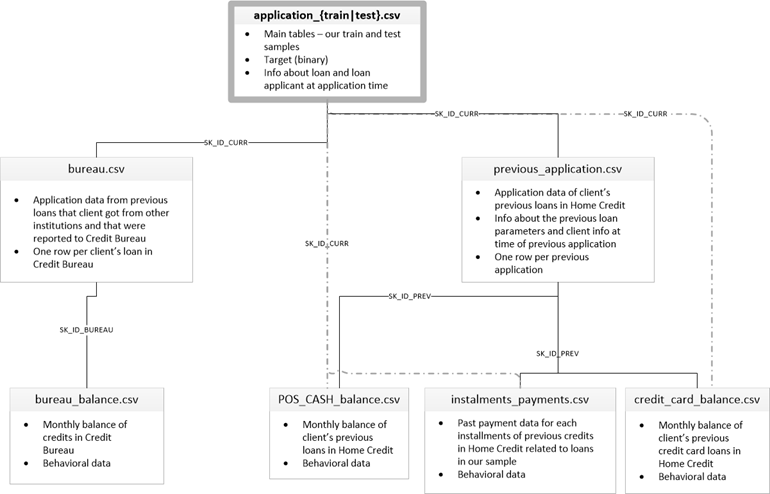

Importation des données

In [ ]:
downloaded = drive.CreateFile({'id':'1EychK1L_5ZhEM8bpiLr60oC4vjhCvWl6'})
downloaded.GetContentFile('application_train.csv')
# Lecture du données
train = pd.read_csv('application_train.csv')

In [ ]:
print('Train data shape: ', train.shape)
train.head()

Train data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


**Features :**

- Chaque pret est spécifié par son **SK_ID_CURR**

- Chaque pret à sa TARGET (0 : ok et 1 : défaillance de paiement)

- FLAG_OWN_CAR : possède sa voiture ou non

- AMT_INCOME_TOTAL : salaire annuel total

- AMT_CREDIT : montant total du crédit

- DAYS_EMPLOYED : nbr de jours travaillés

- EXT_SOURCE_1/2/3 :  Scores de crédit (entre 0 et 1) qui ont été obtenus à partir de différentes agences d'évaluation du crédit ou d'autres sources externes de données financières. Un score eleve indique un risque de defaut plus faible et un score faible indique un risque de defaut de paiment plus eleve.



*   'AMT_ANNUITY' est le montant spécifique de chaque paiement périodique / calculé en fonction du montant total du prêt, du taux d'intérêt, de la durée du prêt et d'autres facteurs tels que les frais.

* "AMT_GOODS_PRICE" est le montant total du bien ou de l'actif que l'emprunteur souhaite financer à l'aide du crédit, que ce soit pour l'achat d'une maison, d'une voiture ou d'un autre actif.



On cherche à prédire la valeur du colonne "TARGET" , la variable prend deux valeurs 0 et 1 :


*   0  représente les clients qui ont payé leur crédit
*   1 représente les clients ayant recontré des problemes pour rembourser leur crédit




In [ ]:
downloaded = drive.CreateFile({'id':'12NK6sD_OEXRoiLbKhDiSfzRL_uzW6Azs'})
downloaded.GetContentFile('application_test.csv')
# Lecture du données
test = pd.read_csv('application_test.csv')

In [ ]:
print('Test data shape: ', test.shape)
test.head()

Test data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


**Analyse exploratoire des données**

In [ ]:
print(f"Nombre d'identifiants de prêts uniques dupliqués : {train.duplicated(subset=['SK_ID_CURR']).sum()}")

Nombre d'identifiants de prêts uniques dupliqués : 0


Il y a bien une ligne par crédit

 - Au niveau de la Target

In [ ]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

/usr/local/lib/python3.10/dist-packages/xplotter/insights.py:504: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, ax=ax, x=x, y=y, hue=hue, order=order, palette=palette)
/usr/local/lib/python3.10/dist-packages/xplotter/insights.py:542: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


Text(0.5, 1.0, 'Répartition dans les deux classes')

<Figure size 300x300 with 0 Axes>

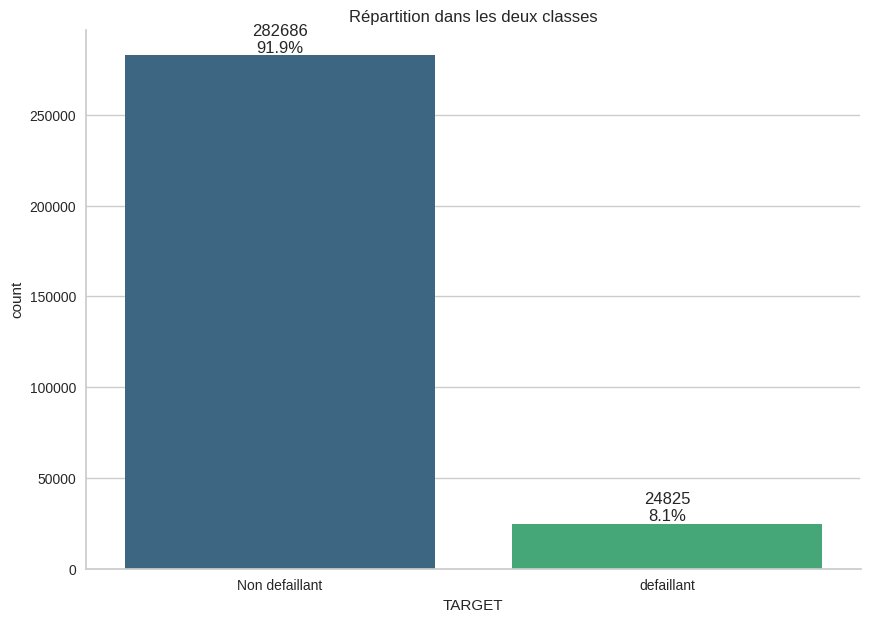

In [ ]:
plt.figure(figsize=(3,3))
label = {1 : "defaillant",0 : "Non defaillant"}
plot_countplot(df=train,col='TARGET', label_names=label,order=True,palette="viridis", orient='v', size_labels=12)
plt.title('Répartition dans les deux classes')

les classes sont déséquilibrées, il y a beaucoup plus d'individus de la classe 0 ( non defaillant ) que de la classe 1 ( defaillant).

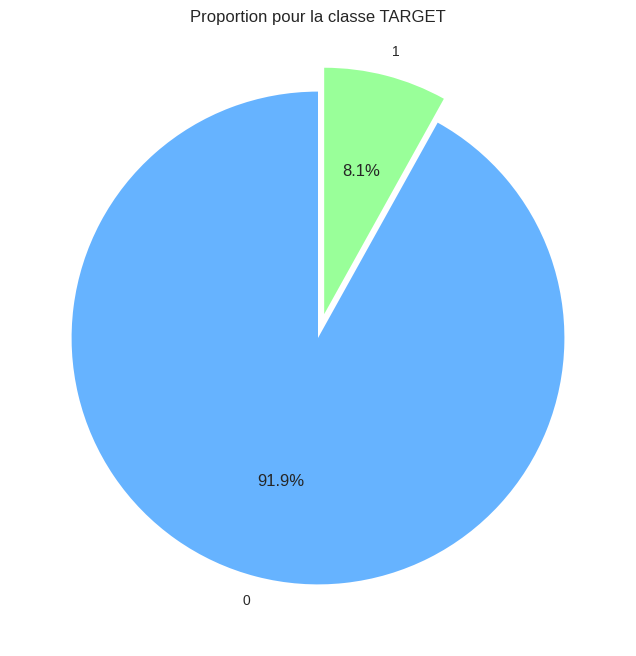

In [ ]:
plt.figure(figsize=(8,8))
colors = ['#66b3ff','#99ff99']
plt.pie(train['TARGET'].value_counts().values,labels=train['TARGET'].value_counts().index,explode=[0, 0.1],startangle=90,autopct='%1.1f%%',colors=colors)
plt.title('Proportion pour la classe TARGET')
plt.show()


91.9 % des prêts ont été remboursés et donc 8.1 % n'ont pas été non remboursés

**Données manquantes**

- % des données manquantes

In [ ]:
train_nan = pd.DataFrame(train.isnull().mean()*100,columns=['%_nan']).sort_values(by='%_nan',ascending=False)

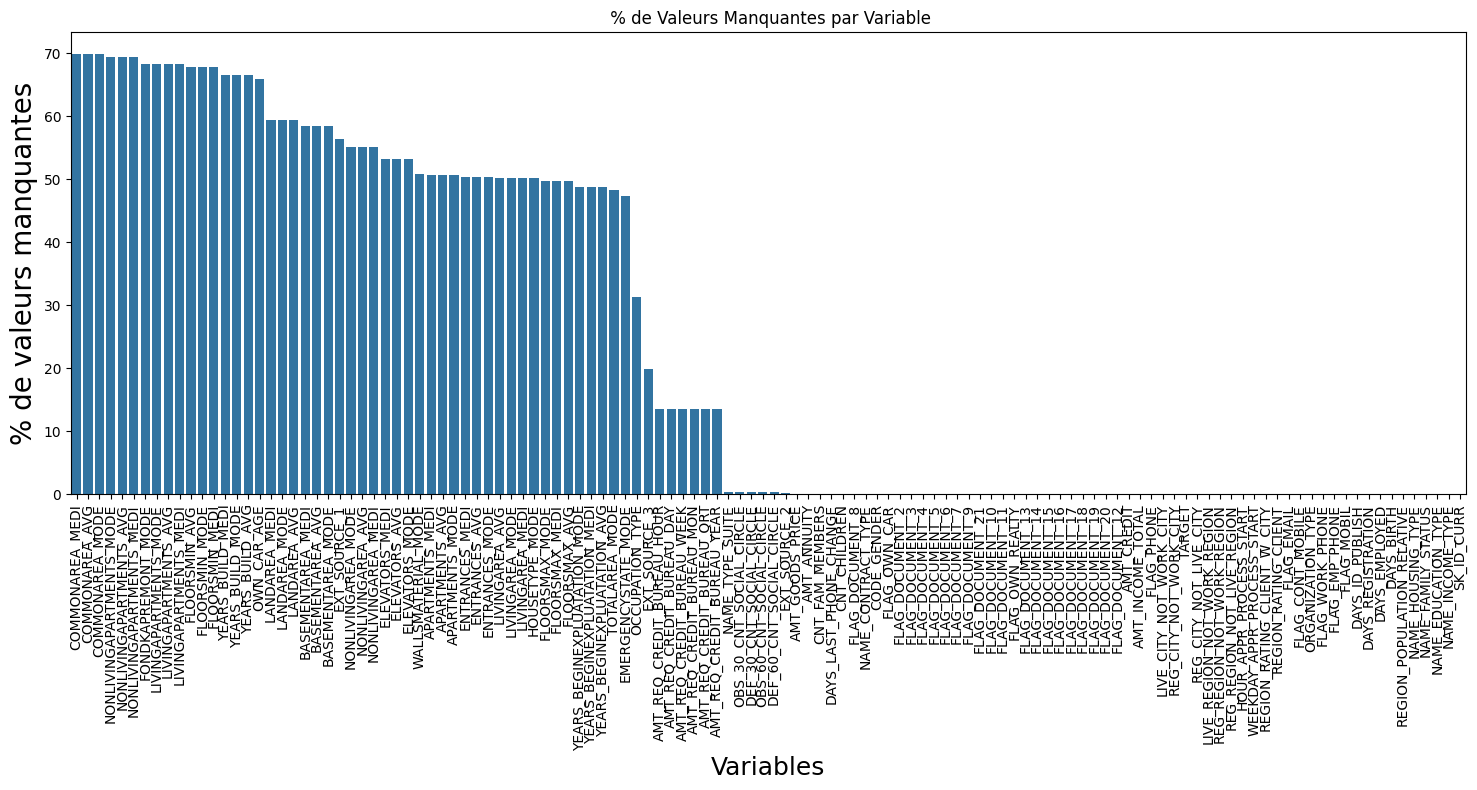

In [ ]:
# Créez un graphique à barres avec Seaborn
plt.figure(figsize=(18, 6))
sns.barplot(x=train_nan.index, y='%_nan', data=train_nan)

plt.title(' % de Valeurs Manquantes par Variable', loc="center")
plt.xlabel('Variables', fontsize = 18)
plt.ylabel('% de valeurs manquantes', fontsize = 20)
plt.xticks(rotation=90)
plt.show()

On a une option de supprimer les colonnes avec une % des valeurs manquantes eleves par contre on va conserver toutes les colonnes pour le moment, car il n'est pas possible de déterminer à l'avance si ces colonnes seront utiles à notre modèle. Par la suite, on devrait remplir ces valuers manquantes par l'imputation, une etape nécessaire pour construire nos modèles d'apprentissage automatique.

**Traitement des variables catégorielles**

Nombres de chaque type de colonne

In [ ]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Analyse rapide du type de features, mais surtout établir un aperçu afin de pouvoir poser une réflexion sur l'encodage des données catégorielles.

On affiche les features avec le type object (variables catégorielles)

In [ ]:
train.select_dtypes('object')

NAME_CONTRACT_TYPE CODE_GENDER  ... WALLSMATERIAL_MODE EMERGENCYSTATE_MODE
0              Cash loans           M  ...       Stone, brick                  No
1              Cash loans           F  ...              Block                  No
2         Revolving loans           M  ...                NaN                 NaN
3              Cash loans           F  ...                NaN                 NaN
4              Cash loans           M  ...                NaN                 NaN
...                   ...         ...  ...                ...                 ...
307506         Cash loans           M  ...       Stone, brick                  No
307507         Cash loans           F  ...       Stone, brick                  No
307508         Cash loans           F  ...              Panel                  No
307509         Cash loans           F  ...       Stone, brick                  No
307510         Cash loans           F  ...              Panel                  No

[307511 rows x 16 columns]

Nombre de variables catégorielle : 16

- Descriptif des variables catégorielles

In [ ]:
train.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [ ]:
for cols in train.columns:
  if train[cols].dtype== object:
    print(cols)
    print(train[cols].unique())
    print(train[cols].nunique())

NAME_CONTRACT_TYPE
['Cash loans' 'Revolving loans']
2
CODE_GENDER
['M' 'F' 'XNA']
3
FLAG_OWN_CAR
['N' 'Y']
2
FLAG_OWN_REALTY
['Y' 'N']
2
NAME_TYPE_SUITE
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
7
NAME_INCOME_TYPE
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
8
NAME_EDUCATION_TYPE
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
5
NAME_FAMILY_STATUS
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
6
NAME_HOUSING_TYPE
['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
6
OCCUPATION_TYPE
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' '

Il est important de comprendre les variables qui influent sur la décision d'attribuer un crédit. Cela implique d'analyser les différents facteurs présents dans notre étude, tels que l'emploi, le genre, les types de crédit, le niveau de revenu et d'éducation, ainsi que le comportement financier général du demandeur.

In [ ]:
def plot_features_cat(data,feature):

    palette_colors = sns.color_palette("viridis", n_colors=data[feature].nunique())
    fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(8,10))

    sns.countplot(data=data,y=feature, order=data[feature].value_counts(ascending=False).index,ax=ax[0])#hue ='TARGET'

    ax[0].set_title(f'Nombre de Prêts par {feature}')
    ax[0].set_xlabel('Nombre de Prêts',fontsize=10)
    ax[0].set_ylabel(f'{feature}')
    for p in ax[0].patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax[0].annotate(percentage, (x, y), fontsize=10, fontweight='bold')



    cat=data.groupby(feature)['TARGET'].mean()*100
    cat=cat.sort_values(ascending=False)
    sns.barplot(y=cat.index, x=cat.values,ax=ax[1])
    for p in ax[1].patches:
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax[1].annotate(f'{width:.1f}%', (width if width > 0 else 0, y),fontsize=10, fontweight='bold')

    ax[1].set_title(f'Pourcentage de Prêts Non Remboursés par {feature}')
    ax[1].set_ylabel(f'{feature}')
    ax[1].set_xlabel('Pourcentage de Prêts Non Remboursés (%)')


plt.show()

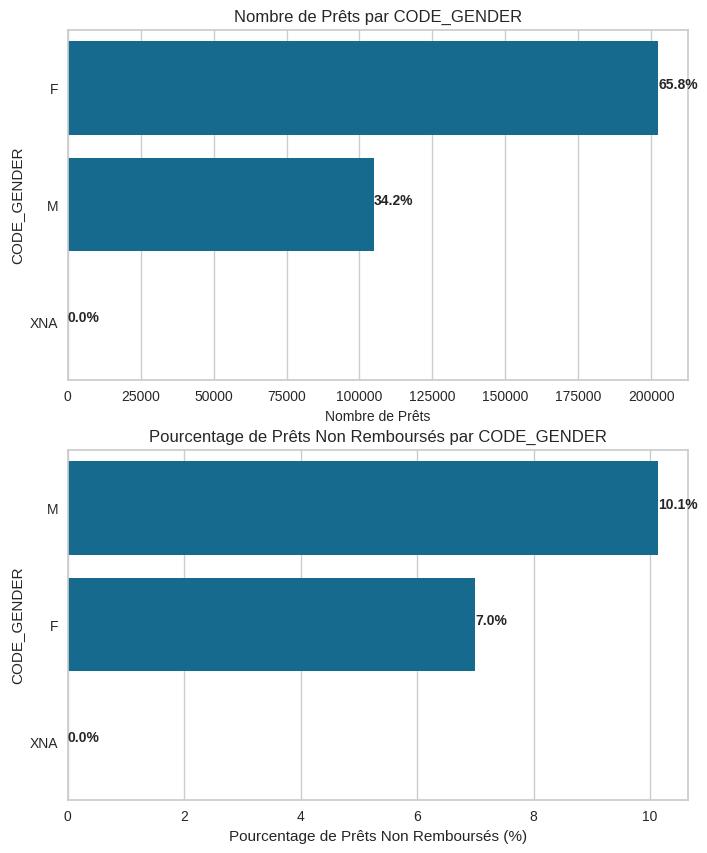

In [ ]:
plot_features_cat(train,'CODE_GENDER')

Le nombre de clients féminins est presque le double du nombre de clients masculins. En ce qui concerne le pourcentage de defaut de paiment, les hommes présentent une pourcentage plus élevée (10%) par rapport aux femmes (7%).

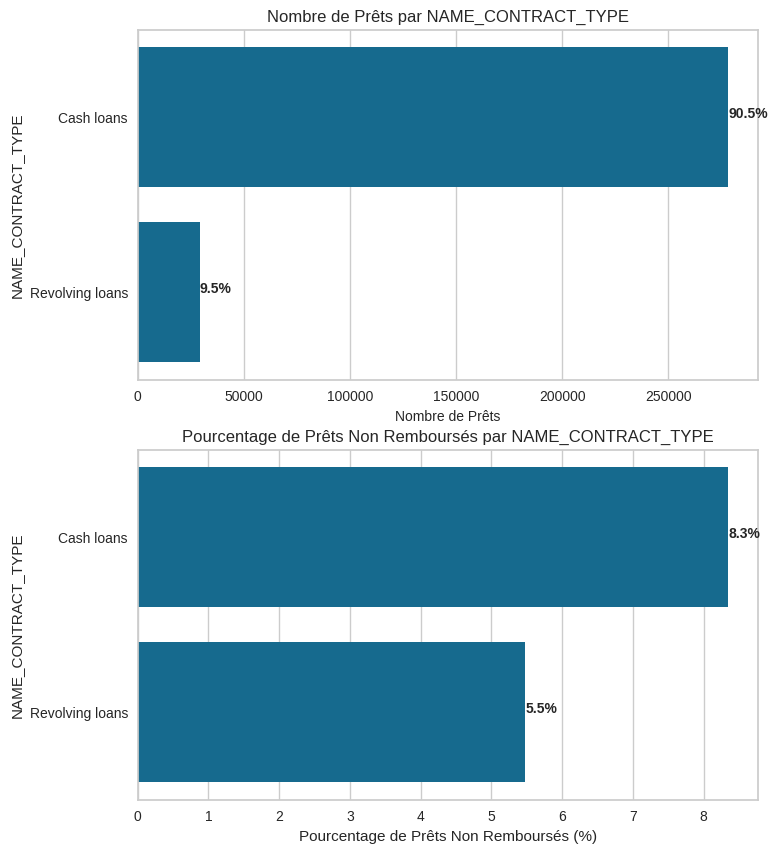

In [ ]:
plot_features_cat(train,'NAME_CONTRACT_TYPE')

la majorite des prêts sont des prêts à la consommation (90%),tandis que les prêts renouvelables, moins nombreux(9.5%), montrent un taux de defaut de paiement plus marqué.

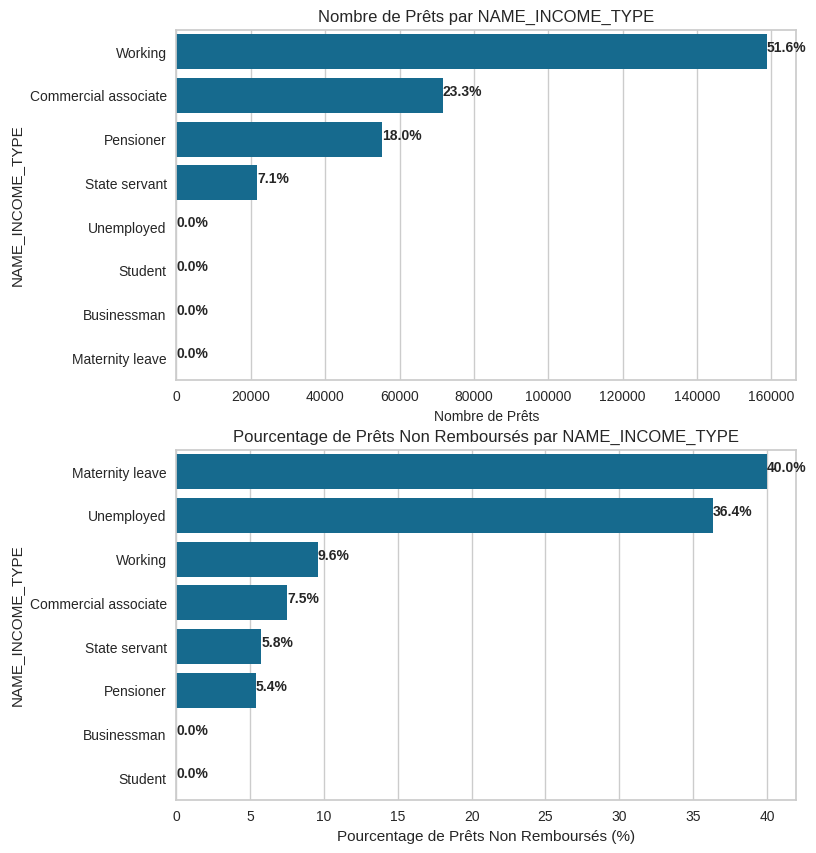

In [ ]:
plot_features_cat(train,'NAME_INCOME_TYPE')

La plupart des demandeurs de prêts sont des revenus du travail, suivis par des commerçants indépendants,des retraités et des fonctionnaires.

Les demandeurs avec le type de revenu Congé de maternité ont un ratio de 40% de prêts non remboursés, suivis des chômeurs (36.4%). Les autres types de revenus sont inférieurs à la moyenne de 10% pour ne pas rembourser les prêts.

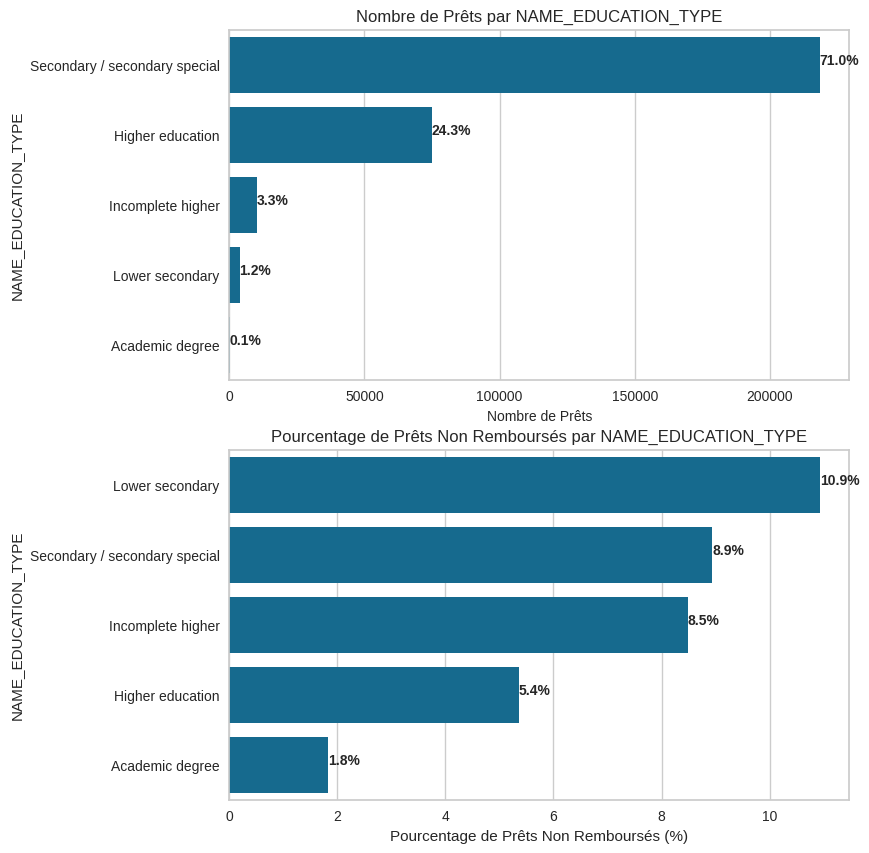

In [ ]:
plot_features_cat(train,'NAME_EDUCATION_TYPE')

La plupart des clients possède un niveau d'éducation secondaire, suivie par ceux ayant atteint l'enseignement supérieur et un très petit nombre de clients possède un diplôme universitaire. En effet, le taux de défaut de paiement pour cette dernière catégorie est inférieur à 2%, tandis que pour ceux avec une éducation secondaire, il s'élève à 11%.

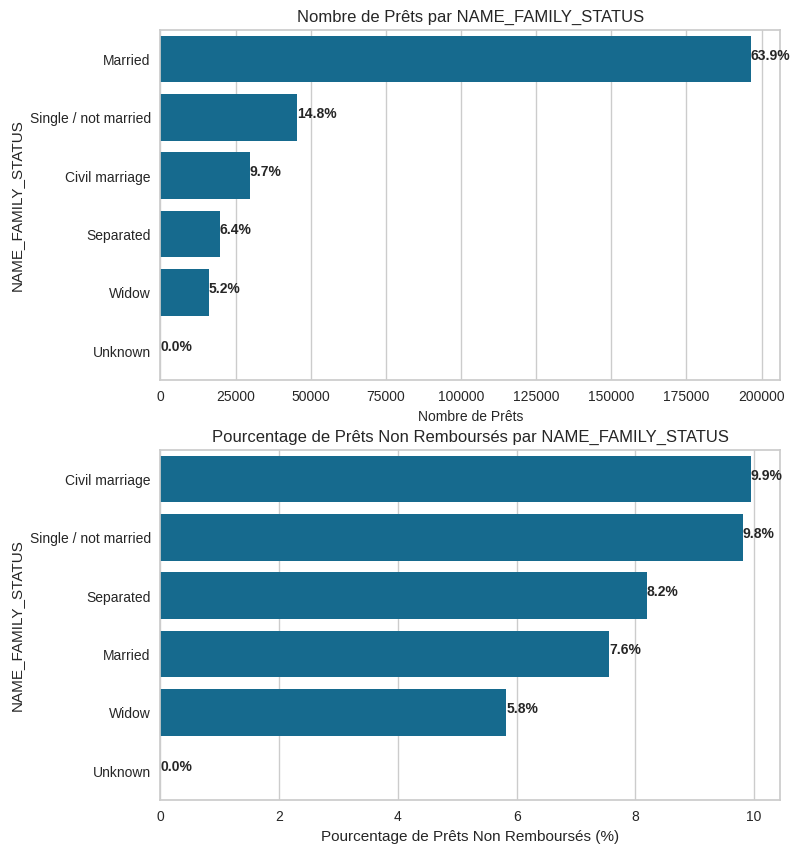

In [ ]:
plot_features_cat(train,'NAME_FAMILY_STATUS')

La plupart des clients sont mariés, suivis des célibataires / non mariés et des mariages civils.

En termes de pourcentage de defaut de paiement du credit , le mariage civil a le pourcentage le plus élevé (10%), la veuve la % le plus bas (5.8%)

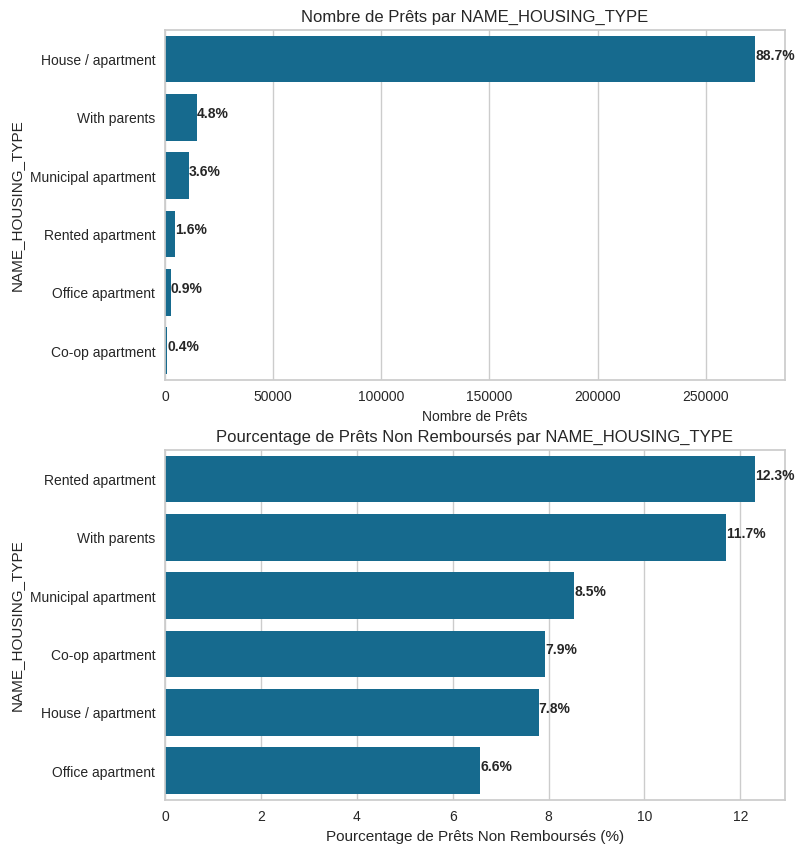

In [ ]:
plot_features_cat(train,'NAME_HOUSING_TYPE')

La majorite de clients vivent en maison ou appartement. suivi par les clients vivre chez ses parents, dans un logement municipal et non propriétaires de leur résidence principale.

les non propriétaires de leur résidence principale, ainsi que ceux qui vivent chez leurs parents, ont un taux de defaut de paiement de leur credit supérieur à 10%.

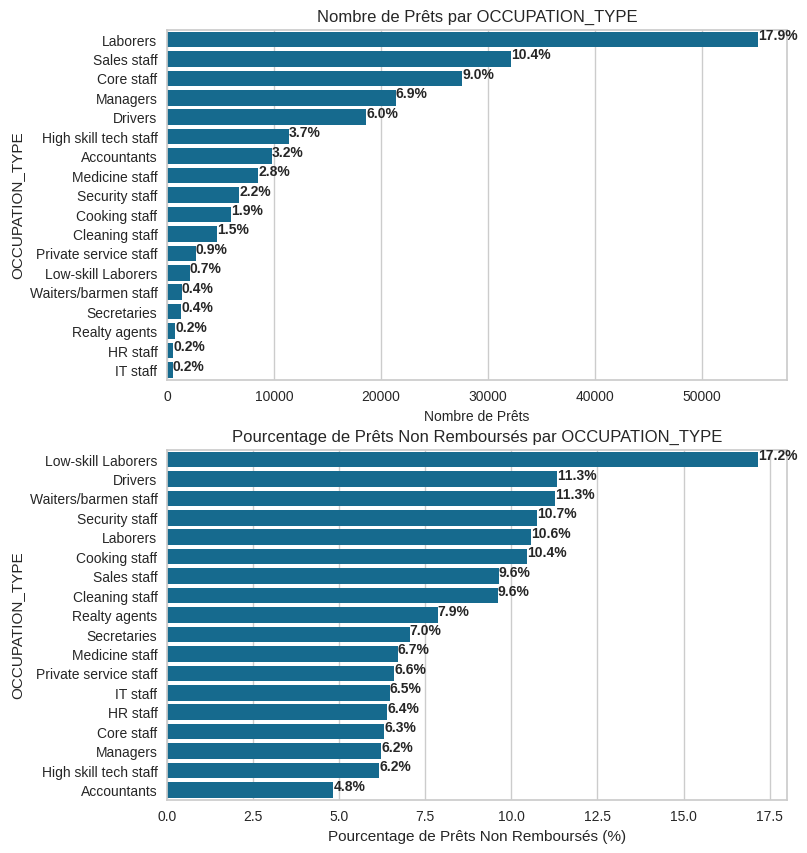

In [ ]:
plot_features_cat(train,'OCCUPATION_TYPE')

La majorite des prêts sont contractés par des ouvriers, suivis par les vendeurs/commerciaux. par contre les professionnels informatique prend le montant de prêts le plus bas.
La catégorie avec le pourcentage le plus élevé de defaut de paiement de credit  est celle des ouvriers plus de 17%, suivis des chauffeurs et des serveurs / barmen, du personnel de sécurité, des ouvriers et du personnel de cuisine.

# **Feature Engineering**

- Encodage des variables catégorielles
- Détection d’outliers /valeurs aberrantes
- Création de nouvelles variables simples
- Imputation des valeurs manquantes
- Normalisation des variables numériques

**Encodage des variables catégorielles**
  - Pour les variables ayant 2 classes ont utilise Label Encoding.
  - Pour les variables ayant > 2 classes ont utilise OHE.

Pour l'encodage par étiquettes, nous utilisons le LabelEncoder de Scikit-Learn et pour l'encodage one-hot, la fonction get_dummies(df) de pandas.

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le_count = 0

for col in train:
    if train[col].dtype == 'object':

        if len(list(train[col].unique())) <= 2:

            le.fit(train[col])

            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])


            le_count += 1

print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [ ]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


L'encodage one-hot a créé plus de colonnes dans train que dans test, en raison de l'existence de catégories dans certaines variables catégorielles qui ne sont pas présentes dans le jeu de test, c'est pour cela qu'on va supprimer les colonnes presentes dans Train mais absentes dans test : aligner les dataframes train et test

In [ ]:
train_labels = train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['TARGET'] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


Le nombre de varibales dans train et test est desormais identiques, ce qui est essentiel pour notre model de ML

**Détection d’outliers /valeurs aberrantes**

In [ ]:
train.select_dtypes(include=['float64','int64']).columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'TARGET'],
      dtype='object', length=109)

In [ ]:
train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

Les nombres dans la colonne DAYS_BIRTH sont négatifs parce qu'ils sont enregistrés par rapport à la demande de prêt actuelle. Pour voir l'age :

In [ ]:
(train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Les âges paraissent justes, sans anomalies.

Pour les jours travaillés :

In [ ]:
train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [ ]:
train['DAYS_EMPLOYED'].max()/365

1000.6657534246575

La valeur maximale est d'environ 1000 ans ! ce qui ne semble pas correct.

Text(0.5, 0, 'Nombre de Jours travaillés')

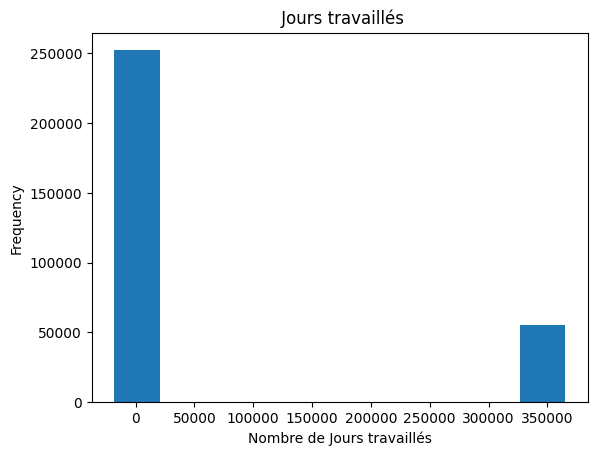

In [ ]:
train['DAYS_EMPLOYED'].plot.hist(title = 'Jours travaillés')
plt.xlabel('Nombre de Jours travaillés')

In [ ]:
#Dataset ayant une anomalie sur la varaible DAYS_EMPLOYED.
anom = train[train['DAYS_EMPLOYED'] == 365243]
#Dataframe n'ayant pas une anomalie sur la variable DAYS_EMPLOYED.
non_anom = train[train['DAYS_EMPLOYED'] != 365243]
print('Les prets sans anomalies ont un taux de defaut de  %0.2f%% ' % (100 * non_anom['TARGET'].mean()))
print('Les prêts avec anomalies ont un taux de défaut de %0.2f%%' % (100 * anom['TARGET'].mean()))
print('Il y a %d jours de travail anormaux' % len(anom))

Les prets sans anomalies ont un taux de defaut de  8.66% 
Les prêts avec anomalies ont un taux de défaut de 5.40%
Il y a 55374 jours de travail anormaux


 Toutes les anomalies presentent la même valeur "365243", donc on va les remplacer par (np.nan) au cas où tous ces prêts auraient quelque chose en commun.  Etant donné l'importance des valeurs anormales, qui représentent un taux de défaut de 5,4 %, alors on va indiquer à notre modele de ML que ces valeurs ont éte traites en creant une nouvelle colonne booléenne "DAYS_EMPLOYED_ANOM" pour indiquer si la valeur etait anormale

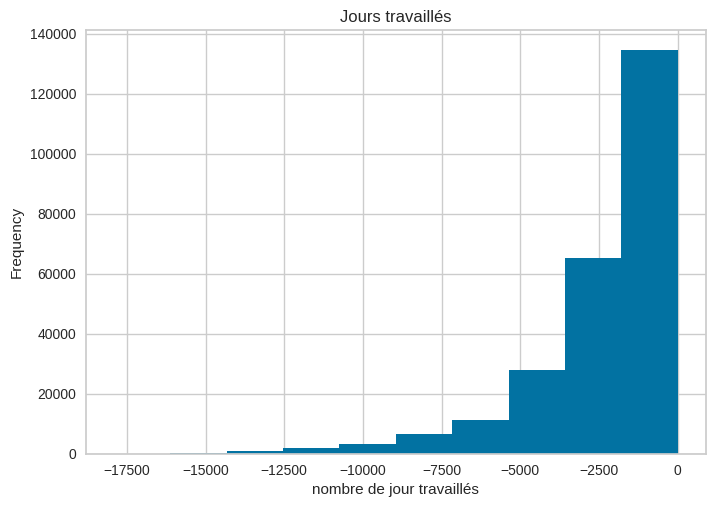

In [ ]:
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
train['DAYS_EMPLOYED'].plot.hist(title = 'Jours travaillés');
plt.xlabel('nombre de jour travaillés');

In [ ]:
test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243
test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
print(' Il y a %d jours de travail anormaux dans le data test ' % test["DAYS_EMPLOYED_ANOM"].sum())

 Il y a 9274 jours de travail anormaux dans le data test 


Text(0.5, 0, 'Nombre de jours travaillés')

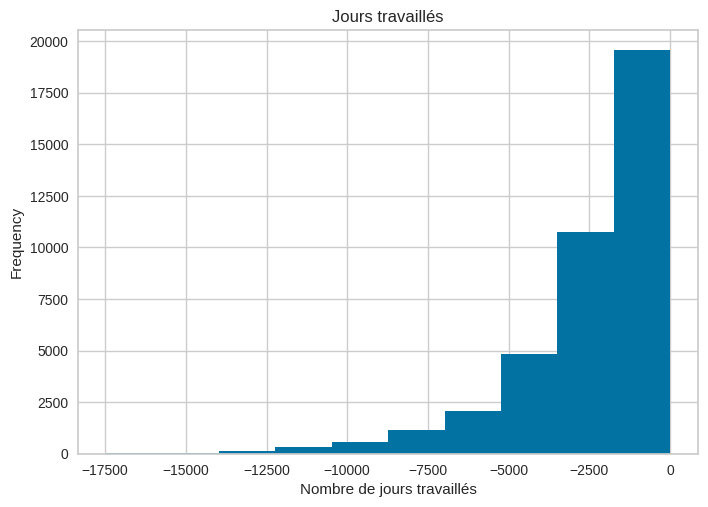

In [ ]:
#Même modification dans le testing set
test['DAYS_EMPLOYED'].plot.hist(title = 'Jours travaillés')
plt.xlabel('Nombre de jours travaillés')

**Check des corrélations**

L'analyse peut continuer par une étape de traitement des corrélations entre les caractéristiques et la Target. L'idée est de calculer le coefficient de corrélation de Pearson entre chaque variable et la Target. Cette étape permet d'avoir un aperçu des relations possibles entre les variables.

Dans cette partie on va chercher les variables les plus corrélées à TARGET : En calculant le coefficient de corrélation de Pearson entre chaque variable et la Target.

In [ ]:
correlations = train.corr()['TARGET'].sort_values()
# Affiche les correlations
print('Les 15 corrélations les plus positives avec TARGET:\n',correlations.tail(15).sort_values(ascending=False) )
print('Les 15 corrélations les plus negatives avec TARGET\n',correlations.head(15).sort_values(ascending=True))

Les 15 corrélations les plus positives avec TARGET:
 TARGET                                               1.000000
DAYS_BIRTH                                           0.078239
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055218
CODE_GENDER_M                                        0.054713
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_DOCUMENT_3                                      0.044346
OCCUPATION_TYPE_Laborers                             0.043019
DAYS_REGISTRATION                                    0.041975
Name: TARGET, dty

Les 3 variables présentant les corrélations négatives la plus forte avec la cible sont EXT_SOURCE_1, EXT_SOURCE_2, et EXT_SOURCE_3, tandis que DAYS_BIRTH affiche la corrélation positive la plus forte avec la cible. on va examiner chacune de ces corrélations.

- DAYS_BIRTH presente la correlation la plus eleve. cette corrélation est positive, mais la valeur de la variable DAYS_BIRTH est en réalité négative, signifiant que  plus le client est age moins la probabilité de défaut de paiement est eleve. Cela peut sembler un peu déroutant, donc on prend la valeur absolue de la caractéristique,ce qui rend la corrélation négative.                                           

In [ ]:
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])
train['DAYS_BIRTH'].corr(train['TARGET'])

-0.07823930830982694

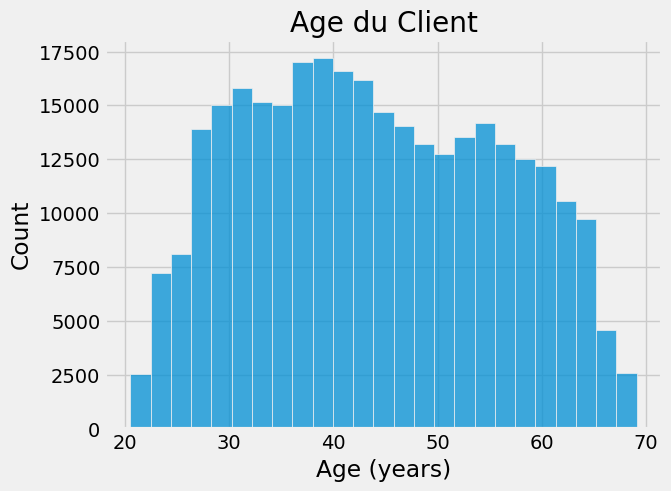

In [ ]:
sns.histplot(train['DAYS_BIRTH'] / 365,bins=25)
plt.title('Age du Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')
plt.show()

Ce graphe ne montre pas grand chose sauf qu'il y pas d'âges aberrants.       
Pour visualiser l'effet de l'âge sur la Target, on peut tracer la distribution des âges en fonction de leur statut de paiement. Cela est realise en faisant un graphique KDE, avec la fonction kdeplot de Seaborn.

Distribution des âges :

Text(0.5, 1.0, 'Distribution des âges')

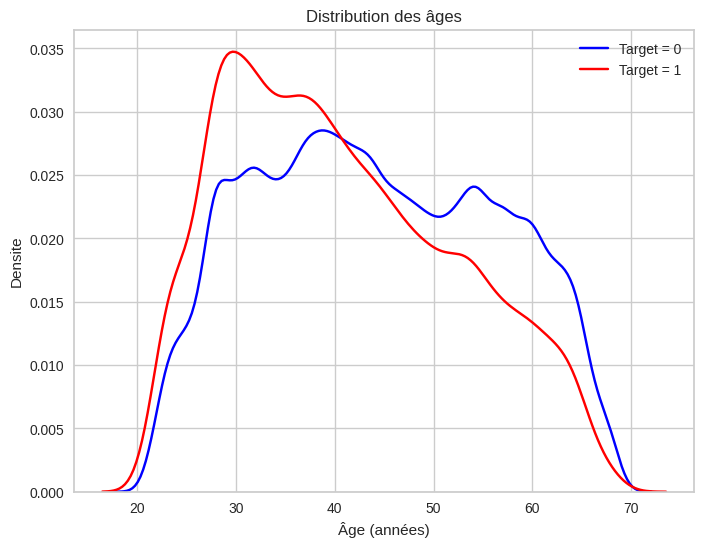

In [ ]:
plt.figure(figsize = (8,6))
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'Target = 0',color='blue')
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'Target = 1',color ='red')
plt.legend()
plt.xlabel('Âge (années)')
plt.ylabel('Densite')
plt.title('Distribution des âges')



* Avant l'âge de 40 ans, la densité de probabilité pour le groupe target == 1 est légèrement plus élevée par rapport à celle du groupe target == 0.Cela pourrait indiquer que les individus en défaut de paiement ont tendance à être légèrement plus jeunes.

*   Après l'âge de 40 ans, la densité de probabilité pour le groupe target == 0 reste un peu plus élevée que pour le groupe target == 1, ce qui pourrait signifier que les individus plus âgés sont un peu moins susceptibles d'être en défaut de paiement.


* Pour les très jeunes et les plus âgés (les extrémités de la distribution), la densité de probabilité semble légèrement plus élevée pour le groupe en défaut de paiement (target == 1). Cela pourrait indiquer que les personnes aux deux extrémités de l'échelle des âges sont plus susceptibles de rencontrer des problèmes de paiement.







 Pour avoir une représentation visuelle  plus claire  sur le du taux de défaillance de paiement par âge :
- Segmenter les âges en tranches de 5 ans.
- Pour chaque intervalle,on calculer la moyenne de la variable cible pour fournir le pourcentage de prêts non remboursés dans chaque tranche d'âge

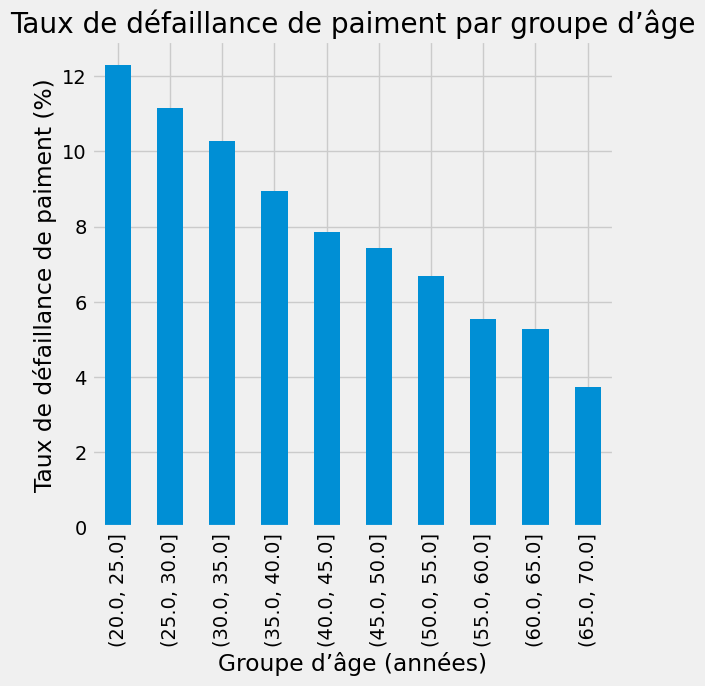

In [ ]:
train['age'] = train['DAYS_BIRTH'] / 365
bins = np.linspace(20, 70, num = 11)
train['Tranche_age'] = pd.cut(train['age'], bins=bins)

# Calcul de la moyenne de la variable cible pour chaque groupe d'âge
age_groups = train.groupby('Tranche_age')['TARGET'].mean()*100
plt.figure(figsize=(6,6))
age_groups.plot(kind='bar', rot=90)
plt.xlabel('Groupe d’âge (années)')
plt.ylabel('Taux de défaillance de paiment (%)')
plt.title('Taux de défaillance de paiment par groupe d’âge')
plt.show()

Les jeunes de moins de 30 ans présentent un taux de défaut supérieur à 10%, et inférieur à 5 % pour le groupe d'âge le plus âgé. Il semble que le taux de defaut de paiement diminue généralement avec l'âge.

Face à cette situation, les banques pourraient réagir en offrant plus de soutien aux jeunes clients en leur proposant un accompagnement et des conseils en gestion financière. Ceci dans le but de reduire les risques de defaut de paiement et de les aider à régler leurs paiement à temps.

**Sources extérieures**

 La distribution des scores de crédit externes (EXT_SOURCE_1, EXT_SOURCE_2, et EXT_SOURCE_3) par rapport au statut de remboursement (Target)

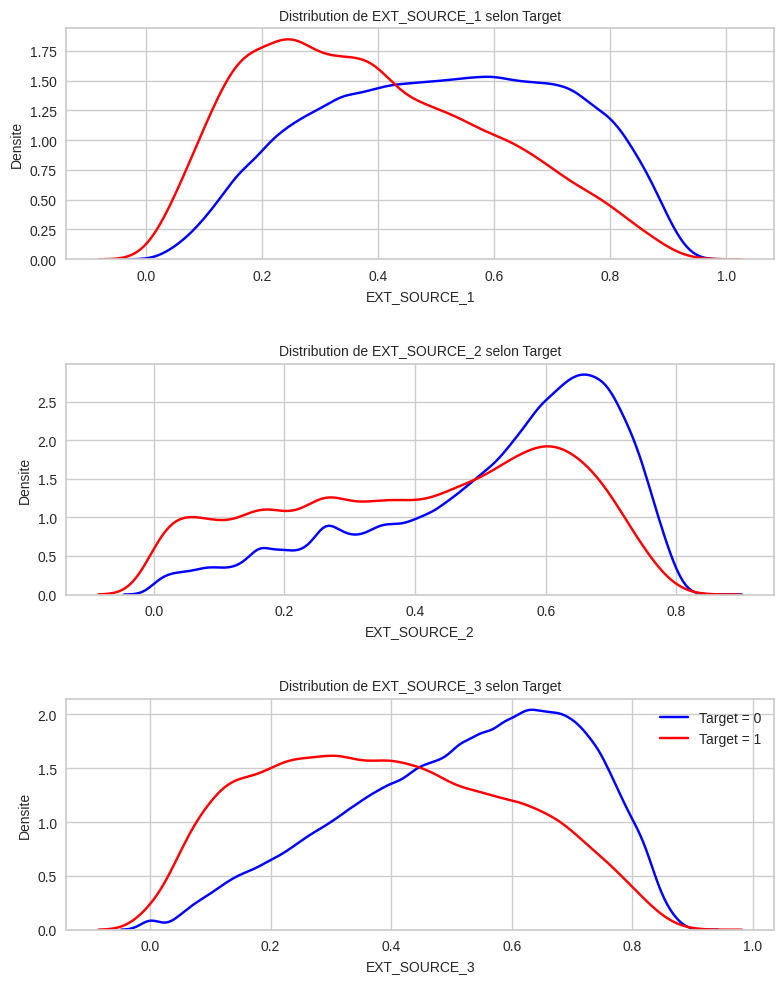

In [ ]:
plt.figure(figsize = (8, 10))
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
  plt.subplot(3, 1, i + 1)
  sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'Target = 0',color='blue')
  sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'Target = 1',color='red')
  plt.title('Distribution de %s selon Target' % source,fontsize=10)
  plt.xlabel('%s' % source,fontsize=10)
  plt.ylabel('Densite',fontsize=10)

plt.tight_layout(h_pad = 2.5)
plt.legend()

Pour les trois sources externes:  

*   les distributions des clients sans défaut de paiement (Target= 0) tendent à avoir des valeurs de score plus élevées que celle de clients avec defaut de paiement (Target = 1). Ceci suggere que des scores plus élevés de ces sources externes sont associés à un moindre risque de défaut de paiement.
*   les distributions des individus avec défaut de paiement (target == 1) sont plus concentrées vers des scores plus bas, ce qui renforce l'idée que des scores inférieurs pourraient signaler un risque plus élevé de defaut de paiement.

Concernant EXT_SOURCE_2, l'observation d'un pic bien défini sur la courbe bleue (Target = 0) aux alentours de 0,6 suggère une faible probabilité de défaut de paiment pour les valeurs autour de ce score.

 Meme si la correlation entre Les EXT_SOURCE et Target n'est pas très forte mais il existe une tendance négative : plus le score EXT_SOURCE est bas, plus le risque de défaut de paiement est élevé. Ces variables seront tout de même utiles pour un modèle d'apprentissage automatique afin de prédir la probabilité de defaut de paiement

L'analyse peut se poursuivre par une étape de traitement des corrélations entre les variables. Cette étape permet d'avoir un aperçu des relations possibles entre différentes caractéristiques.

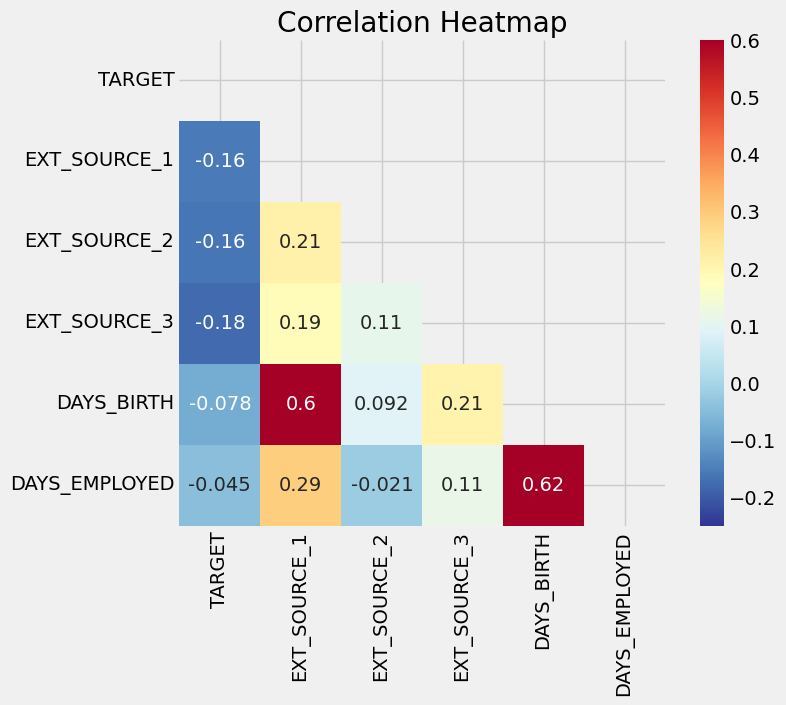

In [ ]:
ext_data = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','DAYS_EMPLOYED']]
plt.figure(figsize = (8, 6))
# Heatmap of correlations
mask = np.triu(np.ones_like(ext_data.corr()))
sns.heatmap(ext_data.corr(),mask= mask, cmap = plt.cm.RdYlBu_r,square= True, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')



*   Absence de corrélation directe forte avec Target : Aucune variable, prise individuellement, ne permet de prédire de manière fiable un défaut de paiement sur un crédit.






*   Les trois variables EXT_SOURCE présentent des corrélations négatives avec la Target, ces coefficients de corrélation sont faibles (-0.16, -0.16, -0.18), mais dans le contexte du risque de crédit, même de faibles corrélations peuvent être significatives.

*  Des corrélations positives faibles entre les variables EXT_SOURCE, allant de 0.11 à 0.21, suggèrent qu'elles ont tendance à augmenter ou diminuer ensemble jusqu'à un certain point.





*   La 1ere correlation importante de 0.62 entre DAYS_EMPLOYED et  DAYS_BIRTH indique que les clients plus âgés ont avoir été employés plus longtemps, ce qui est logique.

*   La 2eme correlation imporante est de 0.6 entre DAYS_BIRTH et EXT_SOURCE_1 suggérant que l'age de client pourrait être un facteur important dans le calcul de EXT_SOURCE_1 où un âge avancé du client, représentant potentiellement une stabilité financière ou une expérience de crédit plus longue.



Pour avoir une vision globales sur l'ensemble des relations entre les varaibles:  on ajoute plus de caractéristiques dans la matrice de corrélation.







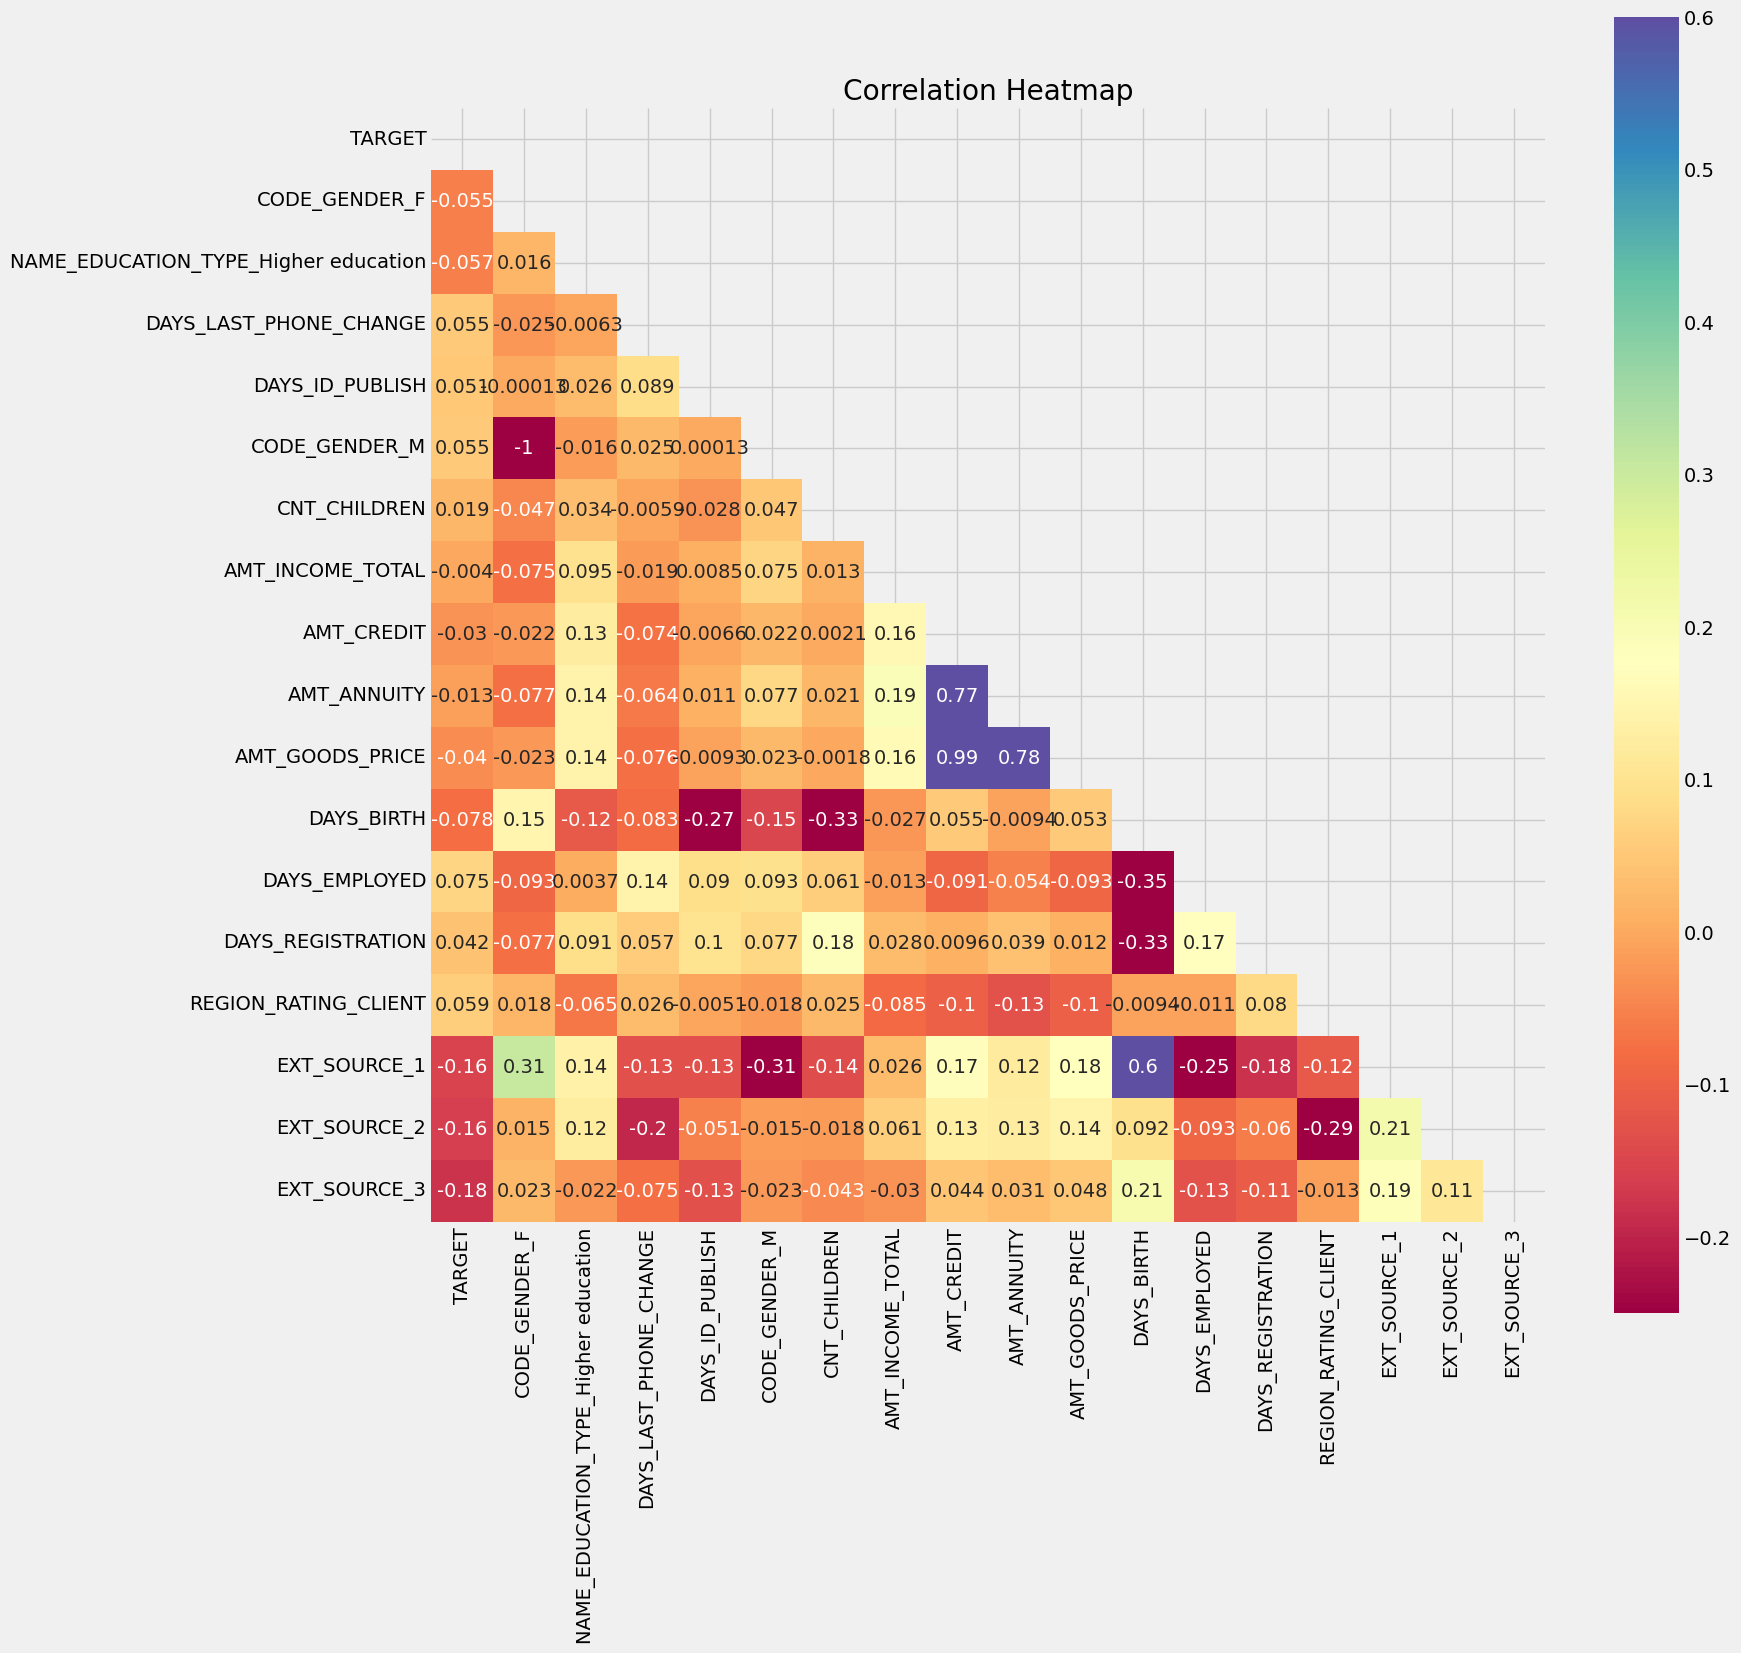

In [ ]:
ext_data = train[['TARGET','CODE_GENDER_F','NAME_EDUCATION_TYPE_Higher education', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH',
 'CODE_GENDER_M',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'REGION_RATING_CLIENT',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3']]

plt.figure(figsize = (16,16))
mask = np.triu(np.ones_like(ext_data.corr()))

# Heatmap of correlations
sns.heatmap(ext_data.corr(),mask = mask, cmap = plt.cm.Spectral,square=True, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');



*  Des corrélations positives entre les variables liées aux montants, comme AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, et AMT_GOODS_PRICE , suggérant une relation proportionnelle entre les revenus de client, les montants de crédit accordés, les annuités, et la valeur des biens financés.



*  Pas de correlation significative entre le genre de client et target, ce qui indique que le genre n'est pas un prédicteur direct du risque de defaut de paiement dans cet ensemble de données.






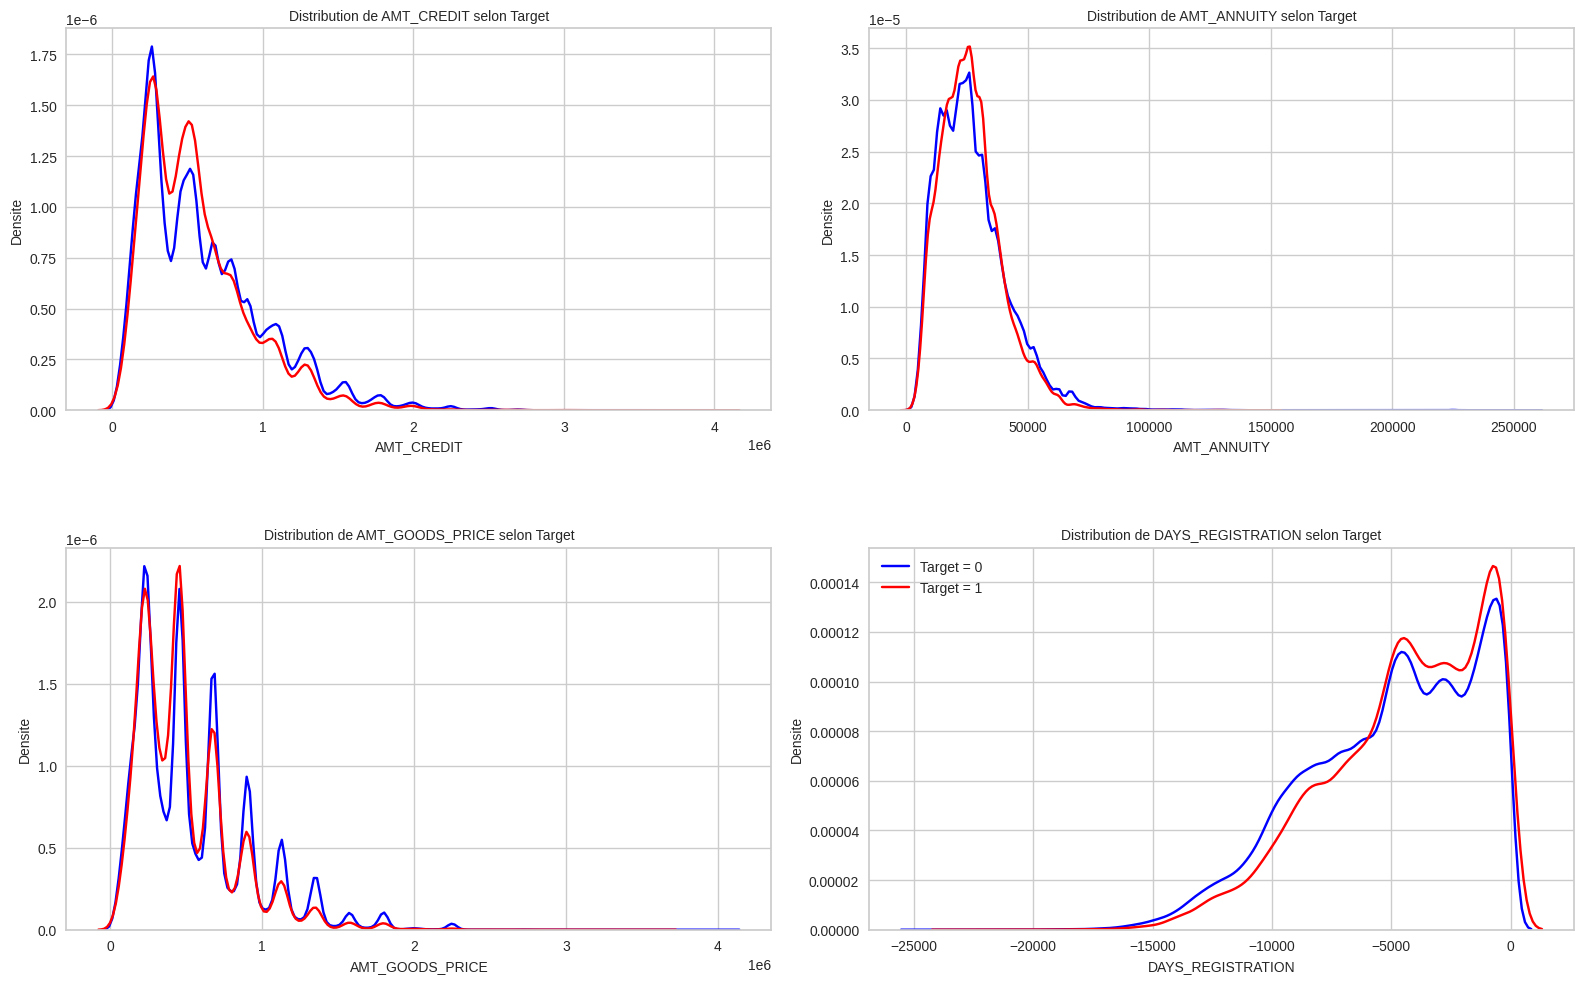

In [ ]:
plt.figure(figsize = (16, 10))
for i, source in enumerate(['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE','DAYS_REGISTRATION']):
  plt.subplot(2, 2, i + 1)
  sns.kdeplot(train.loc[train['TARGET'] == 0, source], color='blue', label = 'Target = 0')
  sns.kdeplot(train.loc[train['TARGET'] == 1, source],color='red', label = 'Target = 1')
  plt.title('Distribution de %s selon Target' % source,fontsize=10)
  plt.xlabel('%s' % source,fontsize=10)
  plt.ylabel('Densite',fontsize=10)

plt.tight_layout(h_pad = 4.5)
plt.legend()

 les clients sans défaut de paiement, ont tendance à avoir des crédits plus élevés et des annuités plus importantes comparativement aux clients avec defaut de paiement,cela indique que le banque accorde  des montants de credit plus substantiels et des conditions de paiement plus importantes aux clients à revenu plus élevé.

Visualize New Variables :

Sans être expert en crédit bancaire, on peut assez facilement apporter quelques ratios explicatifs.Pour voir quelles features est-il pertinent d'intégrer.

CREDIT_INCOME_PERCENT: Pourcentage du montant du crédit par rapport au revenu d'un client

ANNUITY_INCOME_PERCENT: Pourcentage de la rente de prêt par rapport au revenu d'un client

CREDIT_TERM: Durée du paiement en mois

DAYS_EMPLOYED_PERCENT: Pourcentage des jours employés par rapport à l'âge du client

In [ ]:
app_train_domain = train.copy()
app_test_domain = test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [ ]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

- Visualize New Variables

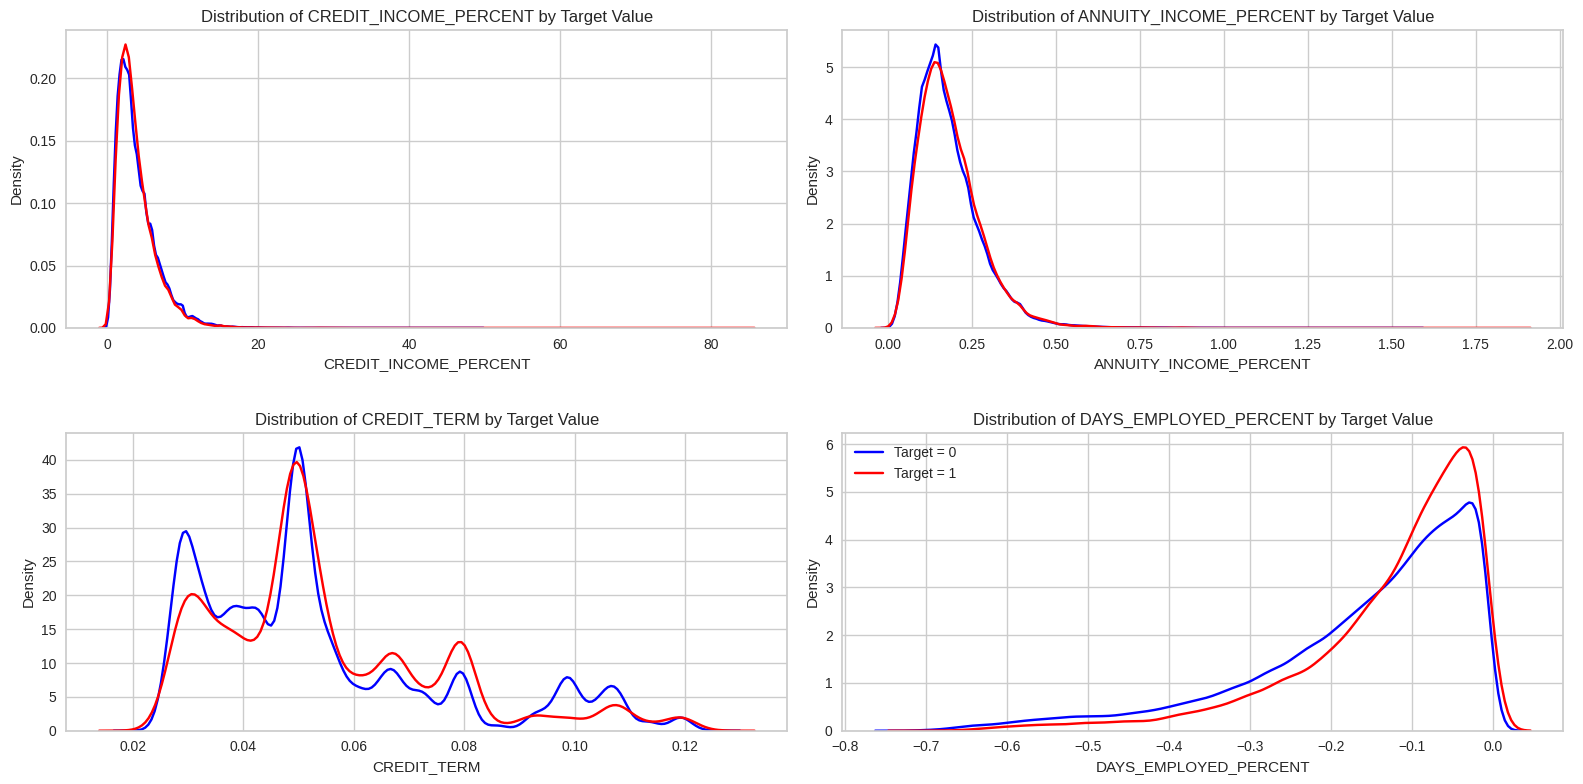

In [ ]:
plt.figure(figsize = (16,8))

for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):

    plt.subplot(2, 2, i + 1)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'Target = 0',color='blue')
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'Target = 1',color='red')
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)
plt.legend()

Les distributions obsrevées des nouvelles variables suggère qu'elles ne révèlent pas de distinctions marquées entre les clasees Target.

**Preprocessing**

Dans cette partie on va  présenter la phase de modelisation,
dans laquelle on va tester les modeles de classification "LGBM" et "RF" sur :

- Données d'entraînement désequilibrées
- Données d'entraînement équilibré, obtenu après échantillonnage.
- Application du paramètre class_weight='balanced' au modèle pour corriger le déséquilibre des classes.
- Optimiser des hyperparamètres des modelés pour améliorer davantage nos résultats.
- Importance des features

et comparer nos résultats via une metrique bancaire adaptée à notre problème bancaire et on d'autres metriques telles que  :
- AUC score
- F1 score  

- Matrice de confusion


Séparation du jeu d'entraînement en :

- Ensemble d'entraînement (Train Set) : 60 % du jeu de données initial pour entraîner les modèles
- Ensemble de validation (Validation Set) : 20 % du jeu de données initial pour évaluer les performances des modèles et sélectionner le meilleur hyperparamtres.
- Ensemble de test (Test Set) : 20 % du jeu de données initial comme test final du modèle sélectionné.

In [ ]:
data=train.copy()

In [ ]:
data["DAYS_EMPLOYED_ANOM"] = data["DAYS_EMPLOYED_ANOM"].astype("int")
df_train = train.drop(['TARGET'],axis=1)
features_names = list(df_train.columns)
targets = data['TARGET']

In [ ]:
# Split en training/testing set.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data,targets, test_size=0.2,random_state=0)

In [ ]:
# Split en training/validation set.
Xtrain, Xvalidation, Ytrain, Yvalidation = train_test_split(Xtrain, Ytrain,test_size=0.25,random_state=0)

In [ ]:
Xtrain.drop(columns=["SK_ID_CURR","TARGET"],inplace=True)
Xvalidation.drop(columns=["SK_ID_CURR","TARGET"],inplace=True)

In [ ]:
print('Xtrain shape: {} \nXvalidation shape: {}\nXtest shape : {}'.format(Xtrain.shape,Xvalidation.shape,Xtest.shape))

Xtrain shape: (184506, 239) 
Xvalidation shape: (61502, 239)
Xtest shape : (61503, 241)


In [ ]:
print('Ytrain shape: {} \nYvalidation shape: {}\nYtest shape : {}'.format(Ytrain.shape,Yvalidation.shape,Ytest.shape))

Ytrain shape: (184506,) 
Yvalidation shape: (61502,)
Ytest shape : (61503,)


- Imputation des valeurs manquantes :

  L'une des approches les plus simples consiste à **remplacer les NaN** par la **Médiane** des variables concernées.


In [ ]:
imputer = SimpleImputer(strategy = 'median')
train_imput = imputer.fit_transform(Xtrain)
val_imput = imputer.transform(Xvalidation)



*   Standardisation des données :




In [ ]:
std = StandardScaler()
train = std.fit_transform(train_imput)
val = std.transform(val_imput)

In [ ]:
X=pd.DataFrame(data=train,columns=Xtrain.columns) #train drop target et ID with std and imputer

**Echantillonage**

Le problème de Machine Learning à résoudre est un problème de classification binaire, pour laquelle il
faut s’assurer que chaque côté contient une proportion raisonnable des classes 0 et 1.
Lors du l’Analyse Exploratoire des Données on a identifie un fort déséquilibre entre la classe 0 et la classe 1 : 8.1 % de clients en défaut de paiment contre 91 % de clients sans défaut de paiement. Cette disproportion peut amener le modèle à prédire la classe la plus fréquente pour la majorité des prédictions,affichant alors une accuracy élevée sans pour autant être capable de détecter correctement les clients de la classe minoritaire.

Compte tenu du déséquilibre des données, il est essentiel d'appliquer des techniques d'échantillonnage afin de rééquilibrer les classes avant de procéder à l'entraînement des modèles LightGBM et RF.Deux approches pour rééquilibrer les deux classes ont été testées:
- Le sous-échantillonnage aléatoire (random undersampling) des observations majoritaires : on retire aléatoirement des observations majoritaires.

- Le sur-échantillonnage aléatoire (random oversampling) des observations minoritaires : on tire au hasard des individus minoritaires que l’on rajoute aux données.

Un autre approche pour traiter le déséquilibre des classes dans notre jeu de données d'entraînement, Par ajuste le modèle de machine learning en intégrant le paramètre class_weight='balanced'. Cette technique affecte un poids plus important a la classe minoritaire. En pratique on va spécifier à notre modèle que le fait de bien classer un point de la classe minoritaire est plus important que de bien classer un point de la classe majoritaire.

**Random oversampling**

- Sur-échantillonnage (Random oversampling): On cherche a agrandir la taille de la classe minoritaire en  rajoutant des individus dans la classe minoritaire d'une maniere aleatoire jusqu'a la distribution soit équilibres

In [ ]:
oversample = RandomOverSampler(random_state=0)#(sampling_strategy='minority') # random_state : contrôle la randomisation interne de l'algorithme
x_over, y_over = oversample.fit_resample(train,Ytrain)

In [ ]:
print('Original dataset shape %s' % Counter(Ytrain))
print('Resampled dataset shape %s' % Counter(y_over))

Original dataset shape Counter({0: 169545, 1: 14961})
Resampled dataset shape Counter({0: 169545, 1: 169545})


In [ ]:
index = pd.Index(y_over)
index.value_counts()

0    169545
1    169545
Name: TARGET, dtype: int64

<ipython-input-99-81ee819fef2c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=index.value_counts().index,y=index.value_counts().values,palette="Blues_d")


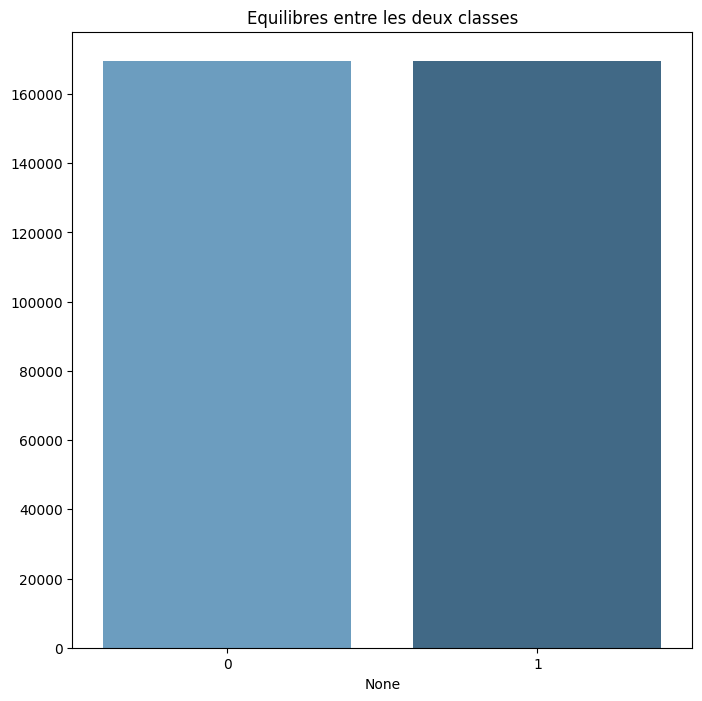

In [ ]:
plt.figure(figsize=(8,8))
sns.barplot(x=index.value_counts().index,y=index.value_counts().values,palette="Blues_d")
plt.title('Equilibres entre les deux classes')
plt.show()

**Random undersampling**

Sous-échantillonnage aléatoire (random undersampling)  :  on chercher a reduire la taille de la classe majoritaire en retirant des individus de la classe majoritaire de facon aléatoire,jusqu'à ce que la distribution des classes soit plus équilibrée.

In [ ]:
undersample = RandomUnderSampler(random_state=0)
x_under, y_under = undersample.fit_resample(train,Ytrain)#df_train["TARGET"]

In [ ]:
print('Original dataset shape %s' % Counter(Ytrain))
print('Resampled dataset shape %s' % Counter(y_under))

Original dataset shape Counter({0: 169545, 1: 14961})
Resampled dataset shape Counter({0: 14961, 1: 14961})


In [ ]:
index = pd.Index(y_under)
index.value_counts()

0    14961
1    14961
Name: TARGET, dtype: int64

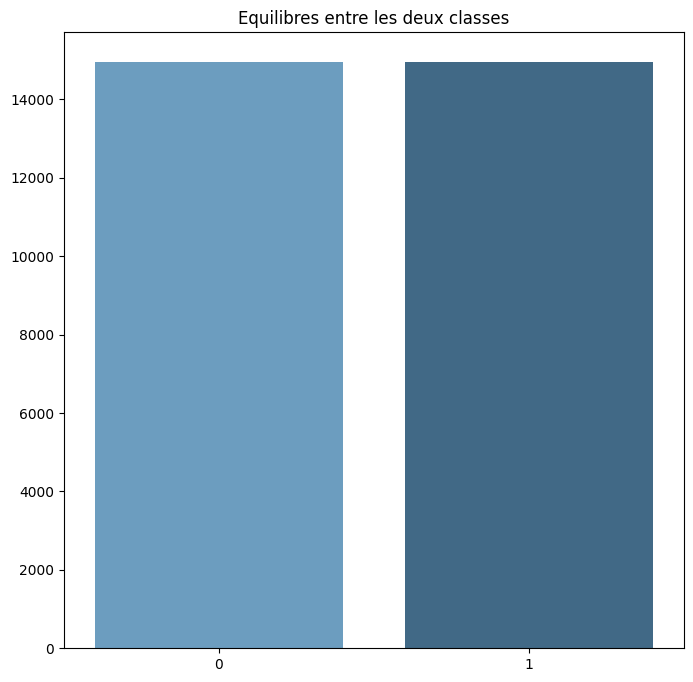

In [ ]:
plt.figure(figsize=(8,8))
sns.barplot(x=index.value_counts().index,y=index.value_counts().values,palette="Blues_d")
plt.title('Equilibres entre les deux classes')
plt.show()

l ne considère pas le coût différentiel associé à chaque type d'erreur

# **Modélisation**

Les modèles de classification à tester sont : Random Foresr Classifier & LightGBM classifier.

En classification binaire, en utilise souvent le pourcentage de bonnes prédictions comme un score. Sauf que ce pourcentage peut être élevé même si le modèle se trompe souvant sur la classe minoritaires. Alors le score va être affecté par le déséquilibre des classes. On pourrait croire que notre modèle est efficace alors qu'il performe essentiellement sur la classe majoritaire.. Pour contourner ce problème, on s'oriente vers des mesures de performance qui ne seront moins sensibles  par la mauvaise répartition des classes. telle que :


**La Précision** : est la proportion des vrais positifs (TP) dans l'ensemble des positifs détectée (TP+FP), Une précision faible suggère un nombre élevé de  FP, pouvant entraîner être une perte de clients pour la société de crédit  (erreur de type I)

**Le Recall** : Indique la proportion des vrais positifs (clients à risque)correctement identifiés par le modèle : TP/TP+FN , Un Recall faible signifie que la majorité des cas positifs sont mal classifiés. ce qui pourrait se traduire par une perte de chiffres d'affaires pour la société de crédit (erreur de type II)


Accorder un crédit à un client qui ne le rembourse pas par la suite est plus grave pour la banque que de refuser un crédit à un client qui aurait pu le rembourser. Autrement dit, une erreur de type II est plus coûteuse pour la banque qu'une erreur de type I.


**Le F1-score** combine la précision et le rappel en un seul indicateur, évitant les pièges liés à l'accuracy.Mais il prend pas en compte le coût différentiel associé à chaque type d'erreur.

**F2 score** : Accorde plus d'importance au recall qu'à la précision.impliquant qu'une erreur de type II est deux fois plus couteuse qu'une erreur de type I, ce qui est essentiel pour minimiser les FN.(c-a-d minimise la perte de chiffres d'affaires pour la société de crédit)

Pour intégrer directement les impacts financiers des différentes issues (FN, TN, FP, TP),on a crée une métrique propre qui considère l'impact financier de chaque type d'erreur. Cette approche apparaît comme étant la plus en adéquation avec les objectifs de la banque.


**Choix de la métrique bancaire propore à la problématique**:

On se place dans un
contexte qu’une société de crédit est une société "à but lucratif". Elle cherche à maximiser ses gains, C'est pourquoi, lors de la création d'un score, en prendre en compte  l’aspect financier, c'est à dire le  gain ou la perte associés à chaque situation possible (FP, TP, FN, TN), en attribuant  un "poids" représentant soit un gain, soit une perte pour l'entreprise, les valeurs
des poids sont les suivantes :



*   Valeur de faux négatifs (fn_value) =-10 : accorder un crédit à quelqu'un qui ne peut pas le rembourser par la suite , représente une perte de chiffres d'affaires pour la sociéte

*   Valeur de vrais négatifs (tn_value ) = 1 : accorder un crédit à un client fiable génère un gain pour la société.

- Valeurs de faux positives (fp_value) = -1 : refuser un crédit à un client qui aurait pu le rembourser, represente une perte de client pour la société.

*   Valeurs de  vrais positives (tp_value)= 2 : refuser un crédit à un client qui peut pas le rembourser.

Les vrais positifs (TP) et les faux négatifs (FN) reçoivent un poids plus important dans le calcul du score, reflétant l'importance de correctement identifier les cas de défaut de paiement qui sont critiques pour la banque.

In [ ]:
#tn=1 tp=2 / tn=0 tp=2/ tn=0 tp=5/tn=0 tp=1
# tn_profit=1, fp_loss=-0.5, fn_loss=-10, tp_profit=0.2

In [ ]:
def metrics(y_true, y_pred, fn_value=-10, tn_value=1, fp_value=-0.5, tp_value=0.2):
  cm = confusion_matrix(y_true, y_pred)
  # Nombre de True Negatifs
  tn = cm[0, 0]
  # Nombre de Faux Négatifs
  fn = cm[1, 0]
  # Nombre de Faux Positifs
  fp = cm[0, 1]
  # Nombre de True Positifs
  tp = cm[1, 1]

   # Gain/perte total(e)
  score = tn*tn_value + fn*fn_value + tp*tp_value + fp*fp_value

  # Gain maximal possible si tous les TN étaient correctement identifiés
  # et tous TP étaient correctement rejetés:
  max_tn = (y_true == 0).sum()
  max_tp = (y_true == 1).sum()

  max_score = max_tn*tn_value + max_tp*tp_value

  # Perte maximale possible si tous clients qui devraient être refusés (vrais positifs) reçoivent un crédit (FN)
  # et tous les clients éligibles (vrais négatifs) sont rejetés (FP)
  min_score = max_tn*fp_value + max_tp*fn_value

  # Gain normalisé entre 0 et 1
  score_normalized = (score - min_score) / (max_score - min_score) #if (max_score - min_score) != 0 else 0


  return score_normalized


In [ ]:
def plot_matrice_confusion(Y_val,Y_pred):

# Affichage de la matrice de confusion
    cm= confusion_matrix(Y_val,Y_pred)
    plt.figure(figsize=(6,6))
    group_names = ['True Negative', 'False Postive', 'False Negative', 'True Positive']
    #Calculer les compteurs et les pourcentages
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    # Créer les étiquettes
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
    # Ajouter les labels aux axes
    plt.ylabel('True Label', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.title('Confusion Matrix', fontsize=15)
    plt.show()

In [ ]:
standard_models = {
    'RandomForest': RandomForestClassifier(),
    'LGBMClassifier': lgb.LGBMClassifier()
    }

balanced_models={
    'RandomForest_balanced': RandomForestClassifier(class_weight='balanced'),
    'LGBMClassifier_balanced': lgb.LGBMClassifier(class_weight='balanced')

}

In [ ]:
# Fonction d'évaluation des modèles
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    pred_proba = model.predict_proba(X_val)[:,1]

    # Calcul des métriques
    auc_score = roc_auc_score(y_val, pred_proba)
    accuracy = accuracy_score(y_val, predictions)
    #precision = precision_score(y_val, predictions)
    #recall = recall_score(y_val, predictions)
    F1 = f1_score(y_val, predictions)


    return accuracy,auc_score,F1,pred_proba

In [ ]:
#plot the roc curve for the model
def plot_ROC_curve(Y_val, pred_proba):
    fpr, tpr, thresholds = roc_curve(Y_val, pred_proba)
    auc_score = roc_auc_score(Y_val, pred_proba)
    # Affichage de la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(auc_score))#label='Random Forest'
    #tracer la ligne de refrence
    plt.plot([0, 1], [0, 1], 'r--',label='No Skill')
    #plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='black', label='Optimal Threshold = {:.2f}'.format(optimal_threshold))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

def calculate_optimal_threshold(Y_val, pred_proba,fpr, tpr, thresholds):

    optimal_idx = np.where(fpr < 0.1)[0][-1]  # Le dernier indice où FPR < 10%
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal Threshold for minimizing Type I errors: {optimal_threshold}")
    # Utilisation du seuil optimal pour générer des prédictions binaires
    optimal_pred = (pred_proba >= optimal_threshold).astype(int)

    # Calcul d'un score personnalisé:
    custom_score = metrics(Y_val, optimal_pred)

    return optimal_threshold, custom_score


In [ ]:
def plot_ROC_curves_with_thresholds(Y_val,model_preds):
    plt.figure(figsize=(10, 8))

    for model_name, pred_proba in model_preds.items():
        # Calcul de la courbe ROC et de l'AUC
        fpr, tpr, thresholds = roc_curve(Y_val, pred_proba)
        auc_score = roc_auc_score(Y_val, pred_proba)

        # Tracer la courbe ROC
        plt.plot(fpr, tpr, label=f'{model_name} ROC (AUC = {auc_score:.2f})')

        # Calcul du seuil optimal (personnalisé ici pour FPR < 10%)
        optimal_idx = np.where(fpr < 0.1)[0][-1]  # Le dernier indice où FPR < 10%
        optimal_threshold = thresholds[optimal_idx]
        optimal_tpr = tpr[optimal_idx]

        # Afficher le point du seuil optimal sur la courbe
        plt.scatter(fpr[optimal_idx], optimal_tpr, marker='o', color='red', label=f'{model_name} Optimal Threshold = {optimal_threshold:.2f}')

    # Ligne de chance
    plt.plot([0, 1], [0, 1], 'r--', label='No Skill')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparaison des courbes ROC avec des seuils optimaux')

    plt.legend(loc="lower right")
    plt.show()




**Baseline model**

In [ ]:

model_preds={}
results_list = []
for model_name, model in standard_models.items():
          accuracy, auc_score,F1,pred_proba = evaluate_model(model,train,Ytrain, val, Yvalidation)
          model_preds[model_name] = pred_proba  # stocker les probabilités prédites
          result_dic={'model':model_name,
                      'accuracy':accuracy,
                      #'precision':precision,
                      #'recall':recall,
                      'auc_score':auc_score,
                      'F1_score':F1}

          results_list.append(result_dic)

results_df_noresampling = pd.DataFrame(results_list)

In [ ]:
results_df_noresampling

model  accuracy  auc_score  F1_score
0    RandomForest  0.918653   0.709458  0.002393
1  LGBMClassifier  0.918799   0.760005  0.029538

In [ ]:
df_long_noresampling = pd.melt(results_df_noresampling, id_vars='model', var_name='metric', value_name='value')

In [ ]:
df_long_noresampling

model     metric     value
0    RandomForest   accuracy  0.918653
1  LGBMClassifier   accuracy  0.918799
2    RandomForest  auc_score  0.709458
3  LGBMClassifier  auc_score  0.760005
4    RandomForest   F1_score  0.002393
5  LGBMClassifier   F1_score  0.029538



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



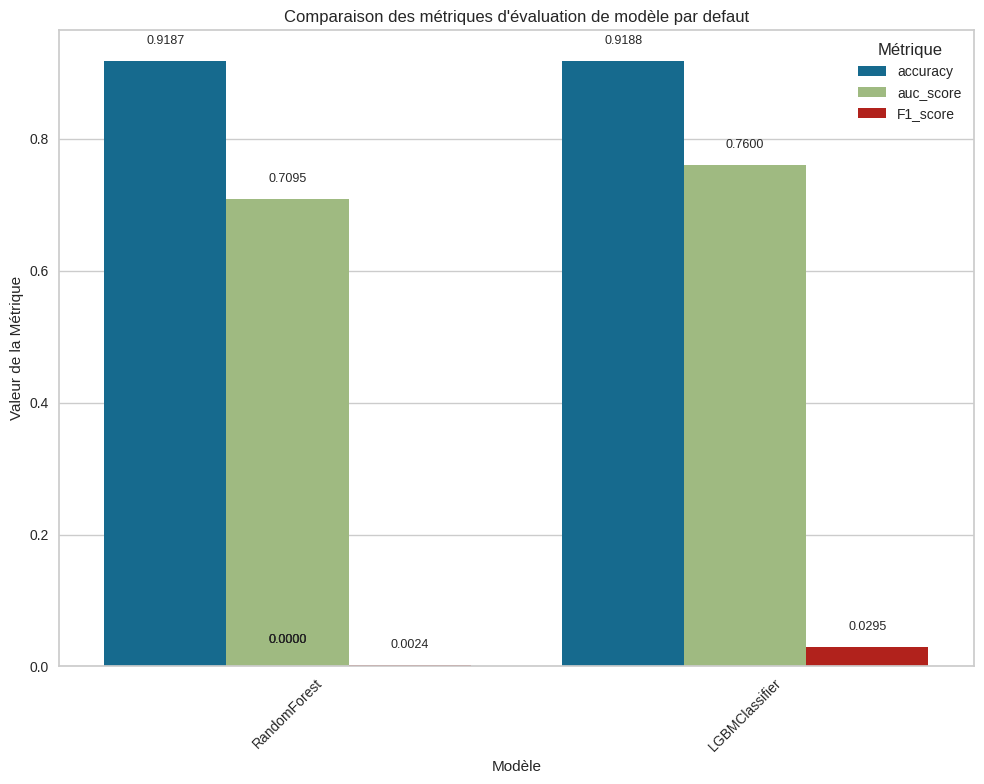

In [ ]:
plt.figure(figsize=(10, 8))
barplot = sns.barplot(x='model', y='value', hue='metric', data=df_long_noresampling, ci=None)

# Initialisez un compteur pour suivre la barre actuelle
for index, p in enumerate(barplot.patches):
    height = p.get_height()
    # Définir une position pour l'annotation, ajuster '10' pour éviter l'overlap
    text_x = p.get_x() + p.get_width() / 2.
    text_y = height if height > 0 else height + 0.01  # Ajustez ce 0.01 si nécessaire pour la visibilité
    # Formater la valeur avec une précision suffisante pour inclure les petites valeurs
    text = f'{height:.4f}' if height != 0 else '0.0000'
    barplot.annotate(text, (text_x, text_y), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', fontsize=9)

plt.title('Comparaison des métriques d\'évaluation de modèle par defaut')
plt.xlabel('Modèle')
plt.ylabel('Valeur de la Métrique')
plt.legend(title='Métrique')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Une accuracy élevée mais cela ne donne pas une image complète en raison du déséquilibre des classes. D'autres métriques, telles que le F1-score, AUC-score, sont également présentées, offrant une perspective plus nuancée de la performance du modèle.

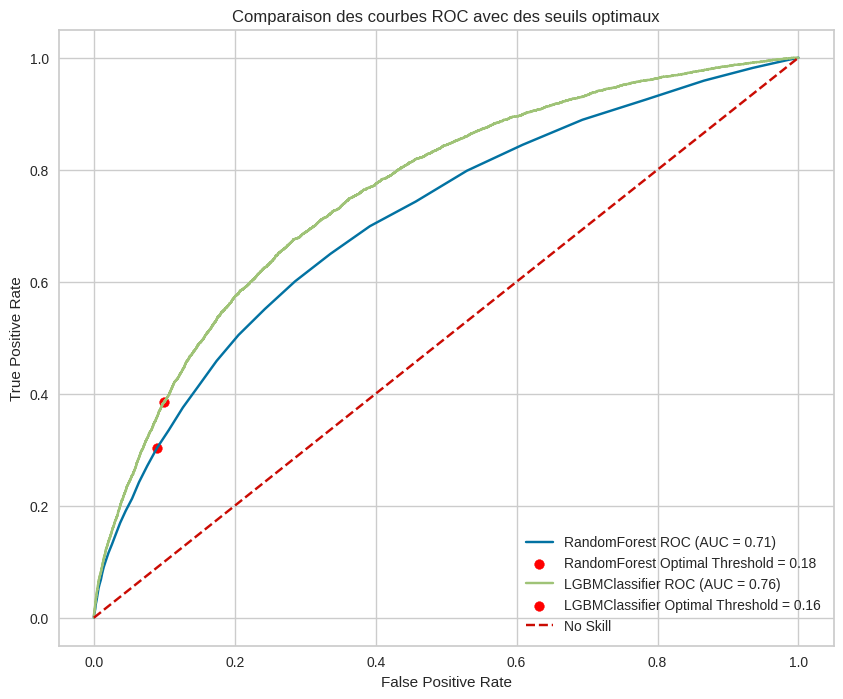

In [ ]:
plot_ROC_curves_with_thresholds(Yvalidation, model_preds)

- Les deux modèles montrent une bonne performance en comparaison à la ligne de "No Skill", avec des AUC de 0.71 pour le RF et de 0.76 pour le LGBM.

- LGBM montre une performance légèrement meilleure en termes d'AUC par rapport au RF.

- Les seuils optimaux affichés (0.18 pour le Random Forest et 0.16 pour le LGBMClassifier) sont relativement bas, cela s'explique par le critère qu'on a  utilisé pour déterminer l'optimalité, qui est de minimiser le FPR à moins de 10%.

**Étuder l'impact de différentes techniques de rééquilibrage des classes sur les performances des modèles LGBM et RF, en se concentrant sur les scores AUC et F1 via :**

- Over-sampling

- Under-sampling

In [ ]:
sampling_data = {
    'oversampling': (x_over, y_over),
    'undersampling': (x_under, y_under)
}

results_dfs = {
    'oversampling': pd.DataFrame(),
    'undersampling': pd.DataFrame()
}

In [ ]:
results_list = []  # Liste pour stocker les dictionnaires de résultats
model_preds = {
    'oversampling': {},
    'undersampling': {}
}
for sampling_type, (X, Y) in sampling_data.items():
    for model_name, model in standard_models.items():
        accuracy, auc_score, F1, pred_proba = evaluate_model(model,X, Y, val, Yvalidation)

        # Créer un dictionnaire de résultats
        result_dict = {
            'strategy': sampling_type,
            'model': model_name,
            'accuracy': accuracy,
            #'precision': precision,
            #'recall': recall,
            'auc_score': auc_score,
            'F1_score':F1
        }

        # Ajouter le dictionnaire à la liste
        results_list.append(result_dict)

        # Stocker les probabilités prédites pour le tracé ROC
        model_preds[sampling_type][model_name] = pred_proba
# Convertir la liste de dictionnaires en DataFrame
results_df_resampling = pd.DataFrame(results_list)



In [ ]:
results_df_resampling

strategy           model  accuracy  auc_score  F1_score
0   oversampling    RandomForest  0.918295   0.730807  0.022183
1   oversampling  LGBMClassifier  0.715147   0.762203  0.276941
2  undersampling    RandomForest  0.690888   0.735439  0.257064
3  undersampling  LGBMClassifier  0.693099   0.758138  0.268042

In [ ]:
results_df_resampling['model_strategy'] = results_df_resampling['strategy'] + " " + results_df_resampling['model']

In [ ]:
df_long_resampling = pd.melt(results_df_resampling, id_vars=['model_strategy'], value_vars=['accuracy', 'auc_score', 'F1_score'], var_name='metric', value_name='value')

In [ ]:
df_long_resampling

model_strategy     metric     value
0      oversampling RandomForest   accuracy  0.918295
1    oversampling LGBMClassifier   accuracy  0.715147
2     undersampling RandomForest   accuracy  0.690888
3   undersampling LGBMClassifier   accuracy  0.693099
4      oversampling RandomForest  auc_score  0.730807
5    oversampling LGBMClassifier  auc_score  0.762203
6     undersampling RandomForest  auc_score  0.735439
7   undersampling LGBMClassifier  auc_score  0.758138
8      oversampling RandomForest   F1_score  0.022183
9    oversampling LGBMClassifier   F1_score  0.276941
10    undersampling RandomForest   F1_score  0.257064
11  undersampling LGBMClassifier   F1_score  0.268042



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



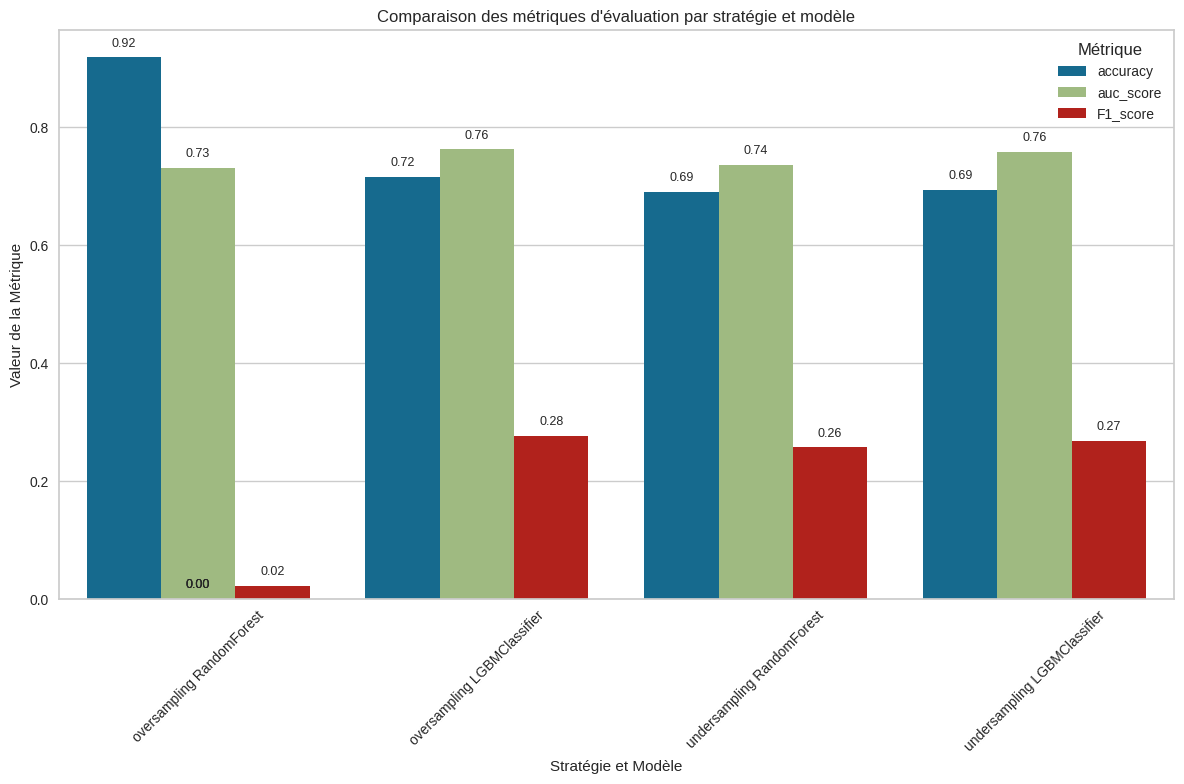

In [ ]:
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='model_strategy', y='value', hue='metric', data=df_long_resampling, ci=None)

# Ajouter les annotations pour chaque barre
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2, height), ha='center', va='center', fontsize=9, xytext=(0, 10), textcoords='offset points')

# Paramétrage du graphique
plt.title('Comparaison des métriques d\'évaluation par stratégie et modèle')
plt.xlabel('Stratégie et Modèle')
plt.ylabel('Valeur de la Métrique')
plt.legend(title='Métrique')
plt.xticks(rotation=45)  # Rotation pour une meilleure lisibilité
plt.tight_layout()  # Ajustement automatique

# Afficher le graphique
plt.show()


In [ ]:
def plot_ROC_curves_with_thresholds_s(Y_val, model_preds):
    plt.figure(figsize=(10, 8))

    # Iterate through each sampling type and each model within that type
    for sampling_type, models in model_preds.items():
        for model_name, pred_proba in models.items():
            # Calculate the ROC curve and AUC
            fpr, tpr, thresholds = roc_curve(Y_val, pred_proba)
            auc_score = roc_auc_score(Y_val, pred_proba)

            # Plot the ROC curve
            plt.plot(fpr, tpr, label=f'{model_name} {sampling_type} (AUC = {auc_score:.2f})')

            # Calculate the optimal threshold (customized here for FPR < 10%)
            optimal_idx = np.where(fpr < 0.1)[0][-1]  # The last index where FPR < 10%
            optimal_threshold = thresholds[optimal_idx]
            optimal_tpr = tpr[optimal_idx]

            # Display the point of the optimal threshold on the curve
            plt.scatter(fpr[optimal_idx], optimal_tpr, marker='o', color='red', label=f'{model_name} {sampling_type} Optimal Threshold = {optimal_threshold:.2f}')

    # Line of no skill
    plt.plot([0, 1], [0, 1], 'r--', label='No Skill')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparaison des courbes ROC avec des seuils optimaux selon différentes méthodes d\'échantillonnage')
    plt.legend(loc="lower right")
    plt.show()


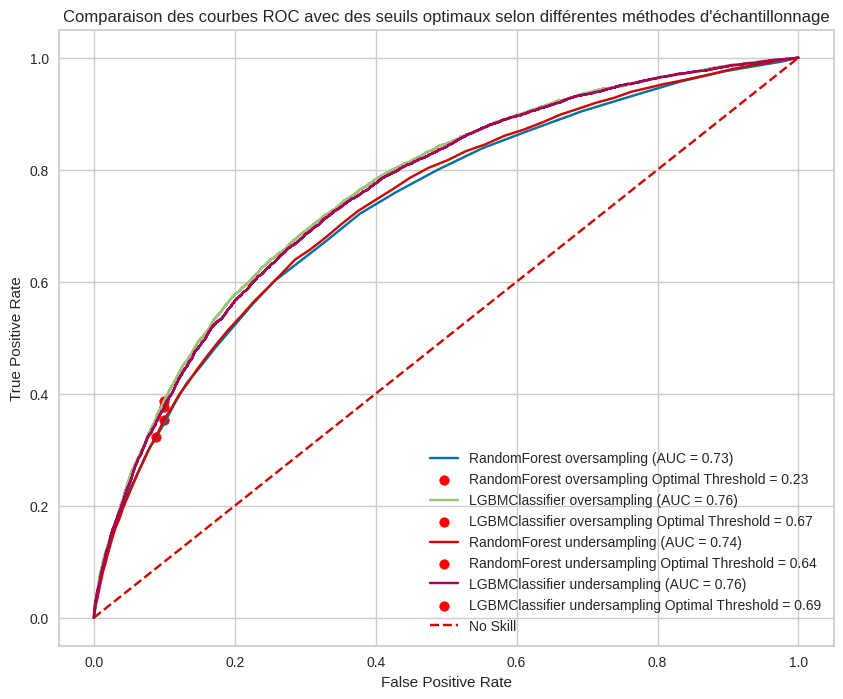

In [ ]:
plot_ROC_curves_with_thresholds_s(Yvalidation, model_preds)

**Tester les performances des modèles LGBM et RF sur la dataset deséquilibrés :Mais en precisions que class_weight='balanced' pour corriger le problème de déséquilibre des classes.**

In [ ]:
model_preds={}
results_list = []
for model_name, model in balanced_models.items():
          accuracy, auc_score,F1,pred_proba = evaluate_model(model,train,Ytrain, val, Yvalidation)
          model_preds[model_name] = pred_proba  # stocker les probabilités prédites
          result_dic={'model':model_name,
                      'accuracy':accuracy,
                      #'precision':precision,
                      #'recall':recall,
                      'auc_score':auc_score,
                      'F1_score':F1}

          results_list.append(result_dic)

results_df_balanced = pd.DataFrame(results_list)

In [ ]:
results_df_balanced

model  accuracy  auc_score  F1_score
0    RandomForest_balanced  0.918555   0.721116  0.002787
1  LGBMClassifier_balanced  0.711148   0.760587  0.276345

In [ ]:
df_long_balanced = pd.melt(results_df_balanced, id_vars='model', var_name='metric', value_name='value')

In [ ]:
df_long_balanced

model     metric     value
0    RandomForest_balanced   accuracy  0.918555
1  LGBMClassifier_balanced   accuracy  0.711148
2    RandomForest_balanced  auc_score  0.721116
3  LGBMClassifier_balanced  auc_score  0.760587
4    RandomForest_balanced   F1_score  0.002787
5  LGBMClassifier_balanced   F1_score  0.276345



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



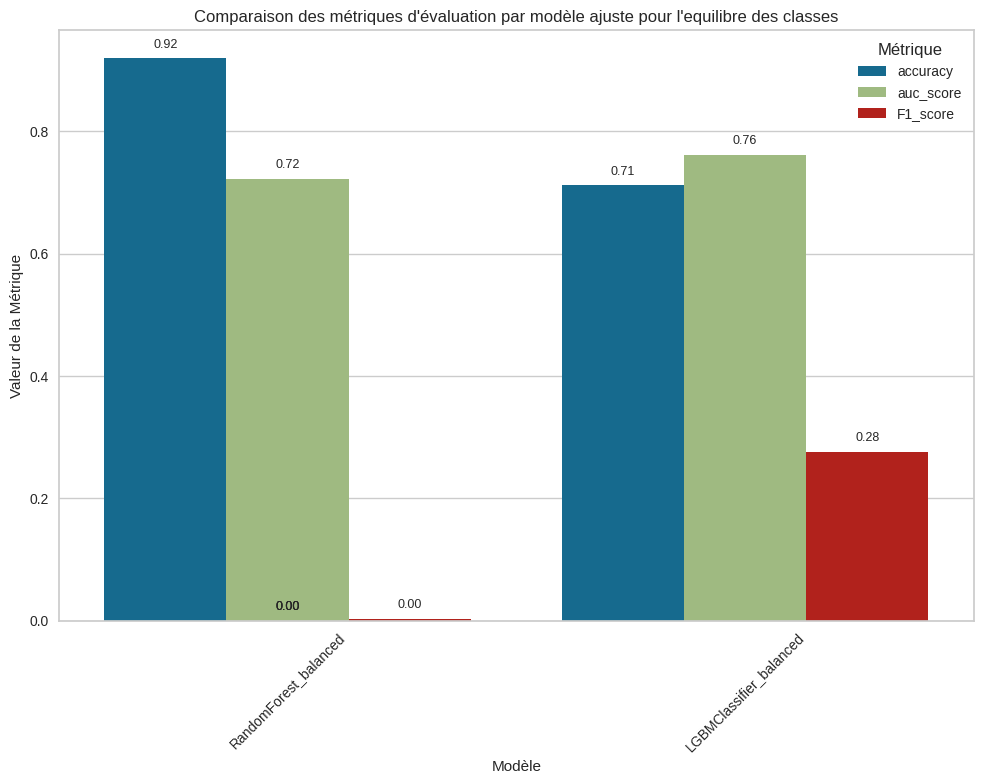

In [ ]:
plt.figure(figsize=(10,8))
barplot = sns.barplot(x='model', y='value', hue='metric', data=df_long_balanced, ci=None)
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2, height), ha='center', va='center', fontsize=9, xytext=(0, 10), textcoords='offset points')

# Paramétrage du graphique
plt.title('Comparaison des métriques d\'évaluation par modèle ajuste pour l\'equilibre des classes')
plt.xlabel('Modèle')
plt.ylabel('Valeur de la Métrique')
plt.legend(title='Métrique')
plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.tight_layout()  # Ajustement automatique des sous-graphiques pour qu'ils tiennent dans la figure

# Affichez le graphique
plt.show()

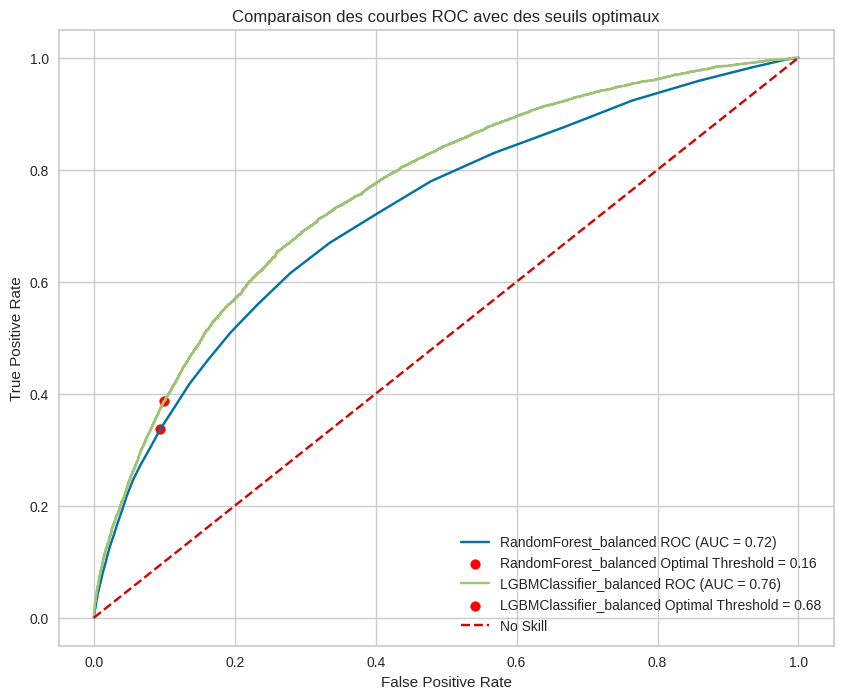

In [ ]:
plot_ROC_curves_with_thresholds(Yvalidation, model_preds)

**Optimisation des hyper-paramètres**  selon une métrique métier bancaire

Les modèles de classification à optimiser :

**Random Forest** :

- n_estimators : Le nombre d'arbres de décision
- max_depth:  La profondeur maximale de l'arbre
- criterions: La fonction pour mesurer la qualité d'un split. « gini » pour l'impureté de Gini et « entropie » pour le gain d'informations.

**Lightgbm** :

- max_depth : contrôle la distance maximale entre le nœud racine de chaque arbre et un nœud feuille. Diminuer max_depth réduit le temps d'entraînement.
- num_leaves: définit le nombre maximal de nœuds par arbre. Diminuer num_leaves réduit le temps de entraînement.
- nestimators: Nombre d'arbres de décision
- learning_rate : Détermine l'impact de chaque arbre sur le résultat final.

- **Technique de validation croisée k-fold** :les données sont divisées en k parties avec une distribution de probabilité uniforme, et dans des données déséquilibrées,certains plis peuvent ne pas avoir ou avoir peu d'exemples de la classe minoritaire.

- **Technique d'échantillonnage stratifié** : Dans un dataset desequlibre l'utilisation de la stratification garantit que chaque division
des données a un nombre égal d'instances de la classe minoritaire

In [ ]:
YTrain=np.array(Ytrain)

In [ ]:
%%time
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, confusion_matrix
from lightgbm import LGBMClassifier
import numpy as np
# fonction à optimiser
def objective(model, params, X, y):


    #params['max_depth'] = int(params['max_depth'])
    params['num_leaves'] = int(params['num_leaves'])
    params['n_estimators'] = int(params['n_estimators'])


    model.set_params(**params)
    cv = StratifiedKFold(n_splits=5)
    y_probs = cross_val_predict(model, X, y, cv=cv, method="predict_proba")[:, 1]

    # Calculer le seuil optimal via ROC curve
    fpr, tpr, thresholds = roc_curve(y, y_probs)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Appliquer le seuil optimal pour obtenir les prédictions binaires
    y_pred = (y_probs >= optimal_threshold).astype(int)

    # Calcul des métriques pour suivi
    main_metric = metrics(y, y_pred, fn_value=-10, tn_value=1, fp_value=-0.5, tp_value=0.2)
    auc = roc_auc_score(y, y_probs)
    f1 = f1_score(y, y_pred)

    result = {
        'loss': -main_metric,  # Minimiser la métrique métier
        'status': STATUS_OK,
        'auc': auc,
        'f1': f1,
        'threshold': optimal_threshold
    }

    return result
#espace de recherche :
space_lgbm = {

    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),# hp.uniform distribution continue
    'num_leaves': hp.choice('num_leaves', np.arange(10, 120, 5)),  #hp.choice est utilisé pour définir une distribution discrète
    'n_estimators': hp.uniform('n_estimators', 2000,4000)#100,3000

    }




space_rf = {
    'n_estimators': hp.uniform('n_estimators', 100, 1000),# nombre d'arbres
    'max_depth': hp.choice('max_depth', np.arange(3, 21, 1)),# de 3 à 20 pas de 1 # profondeur maximale de chaque arbre #hyper discrète
    'criterion': hp.choice('criterion', ['gini', 'entropy'])  # critère de split #hyper discrète
}
#l'aglorithme d'optimisation
def optimize_model(model,space, X, y, evals): # nombre d'iteration
    trials = Trials()
    best = fmin(
        fn=lambda params: objective(model, params, X, y),
        space=space,
        algo=tpe.suggest,
        max_evals=evals,
        trials=trials
    )
    best_params = space_eval(space, best)
    return best_params, trials




CPU times: user 238 ms, sys: 53 ms, total: 291 ms
Wall time: 386 ms


In [ ]:
# Lancer l'optimisation
%%time
model_lgbm = LGBMClassifier(class_weight='balanced')
best_params_lgbm, trials_lgbm = optimize_model(model_lgbm,space_lgbm,train,YTrain, 50)

best_trial = trials_lgbm.best_trial
print("Meilleure perte (Score métier minimisé):", best_trial['result']['loss'])
print("Meilleurs paramètres pour cette perte:", best_params_lgbm)
print("Meilleur seuil (Threshold):", best_trial['result']['threshold'])
print("Meilleur AUC Score:", best_trial['result']['auc'])
print("Meilleur F1 Score:", best_trial['result']['f1'])

100%|██████████| 50/50 [3:15:18<00:00, 234.36s/trial, best loss: -0.6916150778642567]
Meilleure perte (Score métier minimisé): -0.6916150778642567
Meilleurs paramètres pour cette perte: {'learning_rate': 0.01120741191375786, 'n_estimators': 740.6283195200044, 'num_leaves': 55}
Meilleur seuil (Threshold): 0.478808262393343
Meilleur AUC Score: 0.7518277230709702
Meilleur F1 Score: 0.26706136490919274
CPU times: user 1d 35min 8s, sys: 1min 43s, total: 1d 36min 51s
Wall time: 3h 15min 18s


In [ ]:

# Extraire les résultats des trials
results = trials_lgbm.results
params = trials_lgbm.vals

# Créer un DataFrame à partir des paramètres
df_params = pd.DataFrame(params)

# Ajouter les résultats au DataFrame
for key in results[0].keys():
    df_params[key] = [r[key] for r in results]



   learning_rate  n_estimators  num_leaves      loss status       auc  \
0       0.061725   2114.820766           1 -0.672537     ok  0.733584   
1       0.147880   1412.902116           1 -0.668786     ok  0.718140   
2       0.016031    640.669318           6 -0.691520     ok  0.751761   
3       0.129728   2575.367927           8 -0.654947     ok  0.690039   
4       0.044209    484.005131          12 -0.677915     ok  0.742830   

         f1  threshold  
0  0.249948   0.383159  
1  0.246143   0.355647  
2  0.267065   0.486036  
3  0.232621   0.062510  
4  0.254505   0.391943  


In [ ]:
df_params.to_csv('optimization_results_lgbm.csv', index=False)

In [ ]:
from google.colab import files
files.download('optimization_results_lgbm.csv')


In [ ]:
print(df_params)

    learning_rate  n_estimators  num_leaves      loss status       auc  \
0        0.061725   2114.820766           1 -0.672537     ok  0.733584   
1        0.147880   1412.902116           1 -0.668786     ok  0.718140   
2        0.016031    640.669318           6 -0.691520     ok  0.751761   
3        0.129728   2575.367927           8 -0.654947     ok  0.690039   
4        0.044209    484.005131          12 -0.677915     ok  0.742830   
5        0.198874    563.375460          13 -0.660114     ok  0.691081   
6        0.045874   1338.593438           9 -0.671195     ok  0.725400   
7        0.106526   1509.168116           8 -0.651154     ok  0.697529   
8        0.100162   2968.144484          14 -0.654352     ok  0.701671   
9        0.143017    337.757918          13 -0.662803     ok  0.717893   
10       0.102982   2237.700570           7 -0.654491     ok  0.694241   
11       0.161278   2647.188834           2 -0.646081     ok  0.690677   
12       0.078707   1344.120021       

In [ ]:
best_threshold = trials_lgbm.best_trial['result']['threshold']

In [ ]:
best_params_lgbm

{'learning_rate': 0.01120741191375786,
 'n_estimators': 740.6283195200044,
 'num_leaves': 55}

In [ ]:
best_threshold

0.478808262393343

In [ ]:
model_rf = RandomForestClassifier(class_weight='balanced',n_jobs=-1)
best_params_rf, trials_rf  = optimize_model(model_rf,space_rf,train,YTrain, 50)


best_trial = trials_rf.best_trial
print("Meilleure perte (Score métier minimisé):", best_trial['result']['loss'])
print("Meilleurs paramètres pour cette perte:", best_params_rf)
print("Meilleur seuil (Threshold):", best_trial['result']['threshold'])
print("Meilleur AUC Score:", best_trial['result']['auc'])
print("Meilleur F1 Score:", best_trial['result']['f1'])


100%|██████████| 50/50 [2:49:20<00:00, 203.21s/trial, best loss: -0.6744055399627986]
Meilleure perte (Score métier minimisé): -0.6744055399627986
Meilleurs paramètres pour cette perte: {'learning_rate': 0.01120741191375786, 'n_estimators': 740.6283195200044, 'num_leaves': 55}
Meilleur seuil (Threshold): 0.47613640678738034
Meilleur AUC Score: 0.7228590101365696
Meilleur F1 Score: 0.2511328404483663


In [ ]:
print("Meilleurs paramètres pour cette perte:", best_params_rf)

Meilleurs paramètres pour cette perte: {'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 660.1987467632885}


In [ ]:

# Extraire les résultats des trials
results = trials_rf.results
params = trials_rf.vals

# Créer un DataFrame à partir des paramètres
df_params_1 = pd.DataFrame(params)

# Ajouter les résultats au DataFrame
for key in results[0].keys():
    df_params_1[key] = [r[key] for r in results]

In [ ]:
df_params_1.to_csv('optimization_results_rf.csv', index=False)

In [ ]:

files.download('optimization_results_rf.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_params_1

criterion  max_depth  n_estimators      loss status       auc        f1  \
0           1         17    314.056426 -0.644821     ok  0.702901  0.228340   
1           0          2    465.607398 -0.664213     ok  0.716848  0.242662   
2           1          8    584.724988 -0.670737     ok  0.723378  0.248086   
3           1         11    822.914511 -0.660151     ok  0.716986  0.239776   
4           1         10    910.093643 -0.665555     ok  0.719668  0.243898   
5           1          1    211.449244 -0.663581     ok  0.713296  0.241969   
6           1         17    362.968830 -0.653010     ok  0.702579  0.233279   
7           1          8    244.128901 -0.669535     ok  0.723025  0.247069   
8           0          5    382.618689 -0.661180     ok  0.723810  0.241053   
9           0          2    522.398843 -0.654636     ok  0.716651  0.236163   
10          0         14    101.341535 -0.660987     ok  0.705999  0.239189   
11          0          5    710.088733 -0.664432     ok  0.724185  0.243436   
12          0         12    510.056092 -0.663018     ok  0.712655  0.241460   
13          1          0    412.307124 -0.658209     ok  0.709609  0.237708   
14          0          6    498.315687 -0.660015     ok  0.724009  0.240300   
15          1          7    860.941505 -0.663126     ok  0.724556  0.242437   
16          0         12    761.734198 -0.658258     ok  0.713191  0.238171   
17          0          6    574.233808 -0.657503     ok  0.724029  0.238717   
18          1         16    451.050320 -0.654748     ok  0.704383  0.234640   
19          1          3    873.149630 -0.664642     ok  0.720792  0.243303   
20          1          8    649.093138 -0.674270     ok  0.723255  0.251040   
21          1          8    612.071155 -0.664609     ok  0.723386  0.243363   
22          1          8    660.198747 -0.674406     ok  0.722859  0.251133   
23          1         15    972.085793 -0.654700     ok  0.706591  0.234892   
24          1         13    677.635579 -0.667963     ok  0.711205  0.245099   
25          1          4    677.911597 -0.663306     ok  0.722803  0.242482   
26          1          8    783.302238 -0.658247     ok  0.723158  0.239025   
27          1          9    643.339421 -0.666192     ok  0.721231  0.244408   
28          1          8    734.265212 -0.662147     ok  0.723520  0.241723   
29          1          0    994.942238 -0.653771     ok  0.710102  0.234957   
30          1         15    301.169921 -0.662999     ok  0.705686  0.240788   
31          1          8    935.125168 -0.672535     ok  0.723654  0.249580   
32          1         11    809.849429 -0.665295     ok  0.716744  0.243408   
33          1         10    617.806090 -0.661981     ok  0.718923  0.241255   
34          1          1    546.507208 -0.658935     ok  0.713384  0.238608   
35          1          9    457.613386 -0.658395     ok  0.720954  0.238994   
36          1         13    104.410735 -0.660162     ok  0.709066  0.239081   
37          1         17    856.165984 -0.653036     ok  0.703420  0.233409   
38          1          8    702.987096 -0.661116     ok  0.723549  0.240993   
39          1         14    323.583627 -0.665016     ok  0.708300  0.242576   
40          0          2    581.637594 -0.662616     ok  0.717381  0.241601   
41          1          3    655.778935 -0.658438     ok  0.720235  0.238910   
42          1          4    220.079306 -0.667235     ok  0.722297  0.245364   
43          0          7    168.079592 -0.666223     ok  0.721617  0.244489   
44          1         16    413.230821 -0.658227     ok  0.704046  0.236998   
45          0          5    753.731455 -0.658903     ok  0.723540  0.239556   
46          1          8    922.378726 -0.667811     ok  0.723581  0.245769   
47          0         11    536.494734 -0.664282     ok  0.714932  0.242498   
48          1         10    817.930888 -0.655146     ok  0.719264  0.236708   
49          1         12    484.081365 -0.654829     o

Le choix du modèle final a été effectué en retenant le modèle avec la meilleur combinaison d’hyperparamètres qui nous données les meilleurs scores sur le jeu de validation. Ici, on retiendra donc le modele LGBM avec la méthode de Class_Weight, ayant comme score 0.69 et comme hyperparamètres Learning rate égale à 0.011 et le nombre d’estimators égale à 740 et num_leaves egale à 55.

Je travaille sur Google Colab, pour bénéficier de l'accès gratuit au GPU.Mais lors de l'execution de test pour ajuster différents hyperparamètres de LightGBM afin d'améliorer le score, les limites de ressources sont atteinte apres envirion 9h.
Pour gérer les contraintes d'accès au GPU sur Google Colab j'ai utilise Optuna , cet outil permet de sauvegarder les résultats des tests sur Google Drive et reprendre le calcul là où il s'est arrêté chaque fois que les limites sont dépassées.

In [ ]:
x_new=X.copy() #train drop target et Id after std and imputer

In [ ]:
x_new.shape

(184506, 239)

Entrainement du modèle RF optimal

In [ ]:
def evaluate_model_finale(model, X_train, y_train, X_val, y_val,threshold):
    model.fit(X_train, y_train)
    pred_proba = model.predict_proba(X_val)[:, 1]

    # Appliquer le seuil optimal s'il est fourni
    predictions = (pred_proba >= threshold).astype(int)

    # Calcul des métriques
    auc_score = roc_auc_score(y_val, pred_proba)
    f1 = f1_score(y_val, predictions)
    score = metrics(Yvalidation,predictions)

    cm = confusion_matrix(y_val, predictions)

    return score, auc_score, f1, pred_proba, predictions


In [ ]:
optimal_threshold_lgbm=0.478808262393343
optimal_threshold_rf= 0.47613640678738034
rf_shap = RandomForestClassifier(n_jobs=-1,criterion= 'entropy', max_depth= 11, n_estimators= 660,class_weight='balanced',random_state=0)
lgbm_shap = lgb.LGBMClassifier(learning_rate=0.011,n_estimators=740,num_leaves=55,objective='binary',class_weight='balanced',reg_alpha=0.1,reg_lambda=0.1,random_state=0)

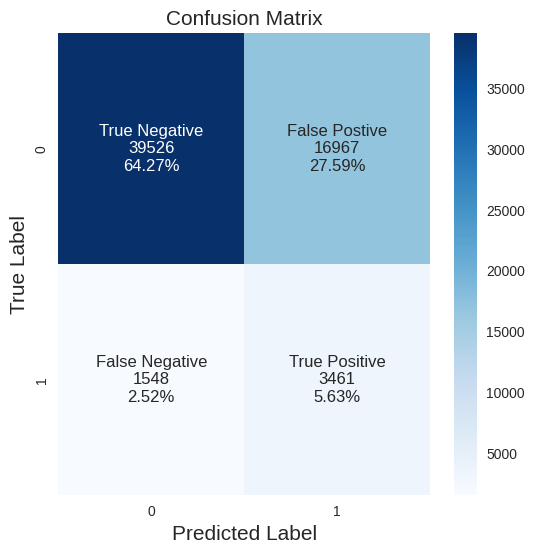

In [ ]:
custom_score_lgbm, auc_lgbm, f1_lgbm, y_probs_lgbm, y_pred_lgbm = evaluate_model_finale(lgbm_shap, x_new, Ytrain, val, Yvalidation, optimal_threshold_lgbm)

# Affichage de la matrice de confusion
plot_matrice_confusion(Yvalidation, y_pred_lgbm)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


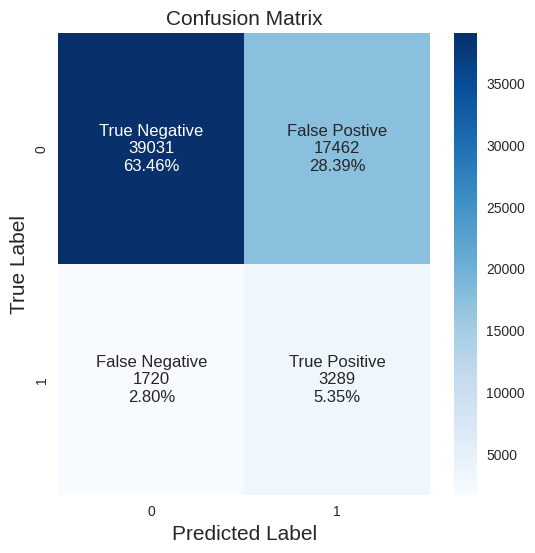

In [ ]:
custom_score_rf, auc_rf, f1_rf, y_probs_rf ,y_pred_rf= evaluate_model_finale(rf_shap, x_new, Ytrain, val, Yvalidation, optimal_threshold_rf)

plot_matrice_confusion(Yvalidation, y_pred_rf)

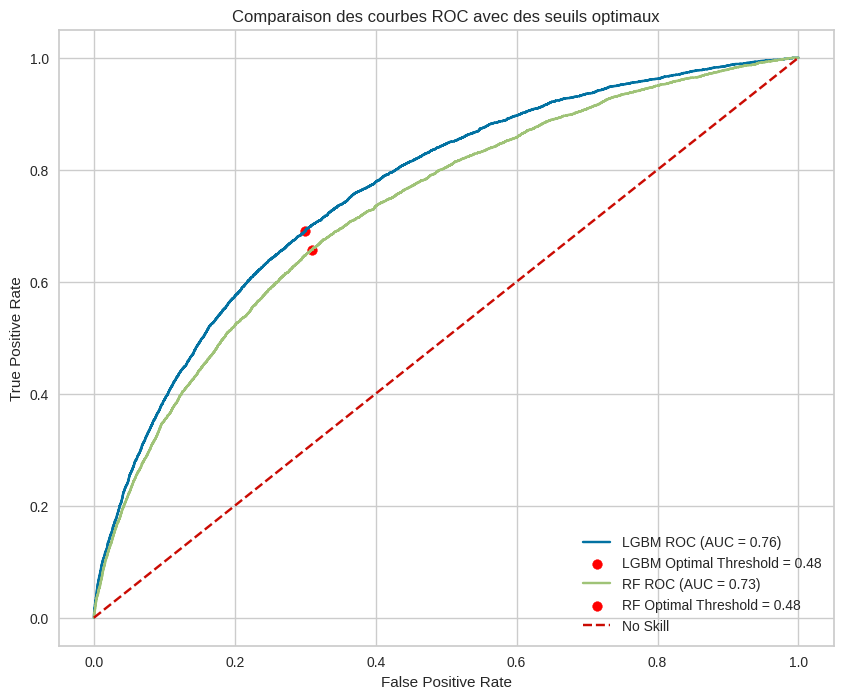

In [ ]:
def plot_ROC_curves_with_thresholds(Y_val, model_preds):
    plt.figure(figsize=(10, 8))

    for model_name, data in model_preds.items():
        pred_proba = data['proba']
        threshold = data['threshold']

        fpr, tpr, thresholds = roc_curve(Y_val, pred_proba)
        auc_score = roc_auc_score(Y_val, pred_proba)

        plt.plot(fpr, tpr, label=f'{model_name} ROC (AUC = {auc_score:.2f})')

        # Trouver le point sur la courbe qui correspond au seuil optimal
        idx = np.argmin(np.abs(thresholds - threshold))
        plt.scatter(fpr[idx], tpr[idx], marker='o', color='red', label=f'{model_name} Optimal Threshold = {threshold:.2f}')

    plt.plot([0, 1], [0, 1], 'r--', label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparaison des courbes ROC avec des seuils optimaux')
    plt.legend(loc="lower right")
    plt.show()


# Préparation des données de prédiction pour le plot ROC
model_preds = {
    'LGBM': {'proba': y_probs_lgbm, 'threshold': optimal_threshold_lgbm},
    'RF': {'proba': y_probs_rf, 'threshold': optimal_threshold_rf}
}

plot_ROC_curves_with_thresholds(Yvalidation, model_preds)

Les performances obtenus avec les modèles optimisés :

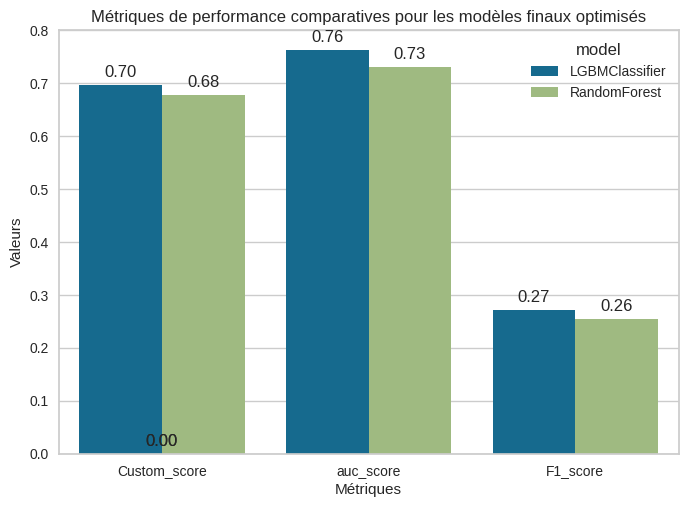

In [ ]:
metrics_data = pd.DataFrame({
    'model': ['LGBMClassifier', 'LGBMClassifier', 'LGBMClassifier', 'RandomForest', 'RandomForest', 'RandomForest'],
    'metric': ['Custom_score', 'auc_score', 'F1_score', 'Custom_score', 'auc_score', 'F1_score'],
    'value': [custom_score_lgbm, auc_lgbm, f1_lgbm, custom_score_rf, auc_rf, f1_rf]
})


ax = sns.barplot(x='metric', y='value', hue='model', data=metrics_data)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),  # formatage des valeurs à deux décimales
                (p.get_x() + p.get_width() / 2., p.get_height()),  # position
                ha = 'center',  # centrage horizontal
                va = 'center',  # centrage vertical
                xytext = (0, 9),  # décalage en points verticaux
                textcoords = 'offset points')
plt.title('Métriques de performance comparatives pour les modèles finaux optimisés')
plt.xlabel('Métriques')
plt.ylabel('Valeurs')
plt.show()


In [ ]:
metrics_data

model        metric     value
0  LGBMClassifier  Custom_score  0.696387
1  LGBMClassifier     auc_score  0.762192
2  LGBMClassifier      F1_score  0.272123
3    RandomForest  Custom_score  0.678005
4    RandomForest     auc_score  0.730592
5    RandomForest      F1_score  0.255357

In [ ]:
df_long_noresampling

model     metric     value     Type
0    RandomForest   accuracy  0.918653  Default
1  LGBMClassifier   accuracy  0.918799  Default
2    RandomForest  auc_score  0.709458  Default
3  LGBMClassifier  auc_score  0.760005  Default
4    RandomForest   F1_score  0.002393  Default
5  LGBMClassifier   F1_score  0.029538  Default

In [ ]:
#ymken lezm jarb balenced w optimise comparaison

<Figure size 1000x800 with 0 Axes>

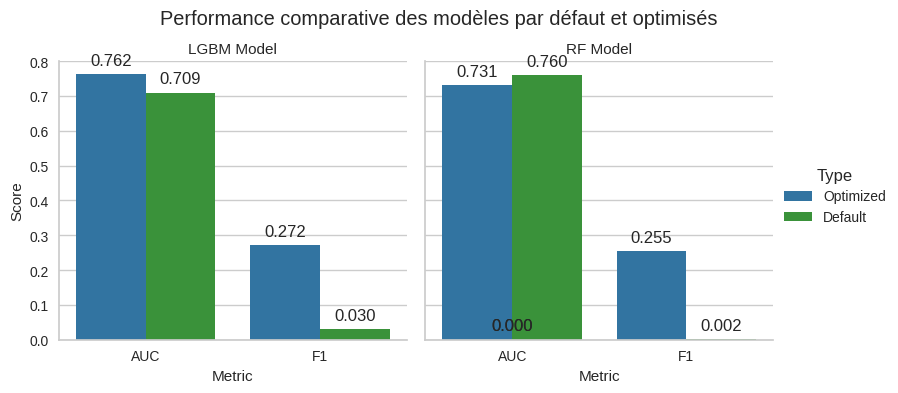

In [ ]:
data = {
    'Model': ['LGBM', 'LGBM', 'RF', 'RF', 'LGBM', 'LGBM', 'RF', 'RF'],
    'Metric': ['AUC', 'F1', 'AUC', 'F1', 'AUC', 'F1', 'AUC', 'F1'],
    'Value': [0.762, 0.272, 0.731, 0.255, 0.709, 0.030, 0.760, 0.002],
    'Type': ['Optimized', 'Optimized', 'Optimized', 'Optimized', 'Default', 'Default', 'Default', 'Default']
}
df = pd.DataFrame(data)
palette_colors = {"Optimized": "#1f77b4", "Default": "#2ca02c"}

plt.figure(figsize=(10,8))
g = sns.catplot(x='Metric', y='Value', hue='Type', col='Model', data=df, kind='bar', height=4, aspect=1, palette=palette_colors)
g.fig.subplots_adjust(top=0.85)  # ajuster l'espace en haut du graphique
g.fig.suptitle('Performance comparative des modèles par défaut et optimisés')
g.set_axis_labels("Metric", "Score")
g.set_titles("{col_name} Model")
g.despine(left=True)
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.3f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points')
plt.show()


- Entrainement du modèle LGBM optimal

In [ ]:
lgbm_shap = lgb.LGBMClassifier(learning_rate=0.011,n_estimators=740,num_leaves=55,objective='binary',class_weight='balanced',reg_alpha=0.1,reg_lambda=0.1,random_state=0)
lgbm_shap.fit(x_new,Ytrain) #  fit sur train (40%)drop id , target with imputer and std

y_probs = lgbm_shap.predict_proba(val)[:, 1]
# Appliquer le seuil optimal pour obtenir les prédictions binaires
optimal_threshold =  0.478808262393343
y_pred = (y_probs >= optimal_threshold).astype(int)
auc = roc_auc_score(Yvalidation, y_probs)
f1 = f1_score(Yvalidation, y_pred)
score = metrics(Yvalidation,y_pred)

In [ ]:
y_probs = lgbm_shap.predict_proba(val)[:, 1]
print(y_probs)

[0.43529616 0.57892755 0.19968228 ... 0.18277135 0.78067281 0.19703391]


Prédiction sur les données de test pour le modèle optimisé selon la métrique bancaire

on a cree un dataframe de résultats de la prediction

In [ ]:
prediction = pd.DataFrame(Xtest,columns=['SK_ID_CURR','TARGET'])
prediction['SK_ID_CURR']=prediction['SK_ID_CURR'].astype('int64')
x_test=Xtest.drop(columns=['TARGET','SK_ID_CURR'],axis=1)
X_test_scale = std.transform(x_test)

X has feature names, but StandardScaler was fitted without feature names


In [ ]:
prediction['predic_proba'] = lgbm_shap.predict_proba(X_test_scale)[:,1] #proba retournée par le classifieur LGBM

prediction['predict'] = (prediction['predic_proba'] >= optimal_threshold).astype(int)
#prediction['predict']=(prediction['predic_proba']>=0.5).astype(int)

prediction['TARGET'] = prediction['TARGET'].astype(int)

In [ ]:
prediction

SK_ID_CURR  TARGET  predic_proba  predict
42962       149741       1      0.828641        1
227307      363290       0      0.162556        0
290035      436006       0      0.373897        0
239833      377703       0      0.246243        0
76427       188624       0      0.799491        1
...            ...     ...           ...      ...
2412        102817       0      0.323627        0
210532      343961       0      0.532466        1
283036      427828       0      0.226957        0
264211      405956       0      0.453615        0
281240      425814       1      0.230919        0

[61503 rows x 4 columns]


Dans cette dernière partie, on cherchera à interpréter les features de notre modèle afin de selectionner les features pertinentes pour les visualisations dans le dashboard.

**Importance des features**

In [ ]:
shap.initjs()  # nécessaire pour tracer les force plots

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


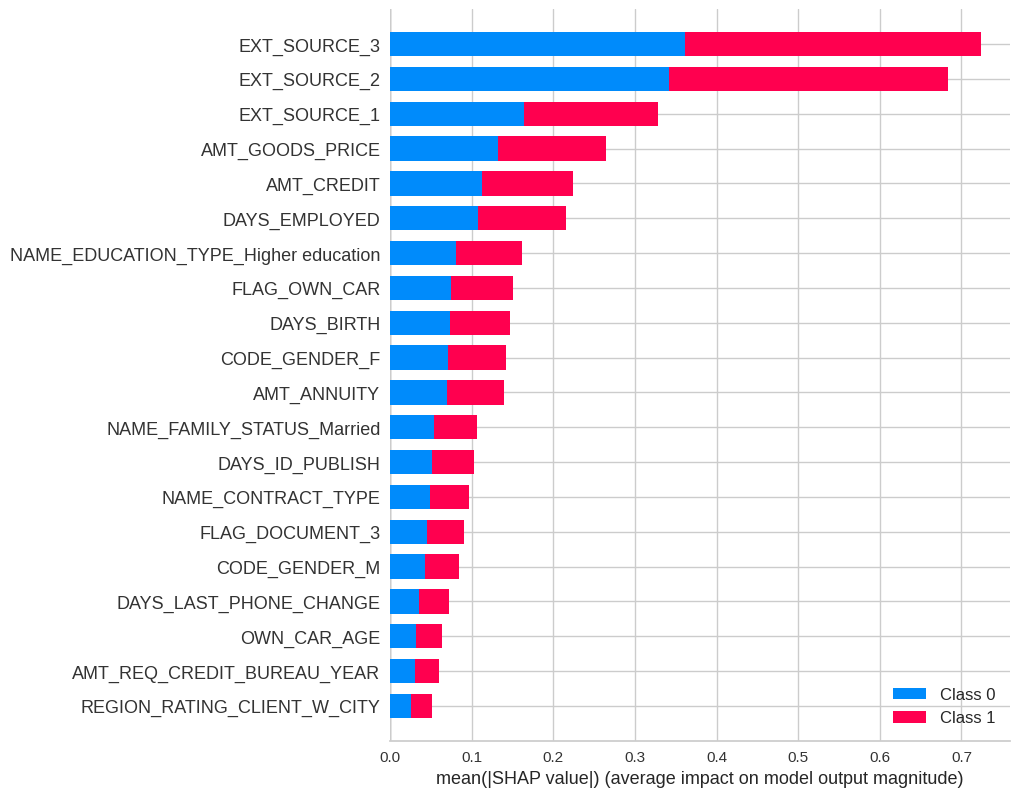

CPU times: user 1h 50min 37s, sys: 15.5 s, total: 1h 50min 53s
Wall time: 1h 8min 24s


In [ ]:
%%time
#lgbm_shap : modèle final selectionné with best_params
explainer = shap.TreeExplainer(lgbm_shap)
shap_values = explainer.shap_values(x_new)
shap.summary_plot(shap_values,x_new)#[1]

In [ ]:
#explainer.expected_value[1] est l'espérance de la classe positive (classe 1) de l'explainer SHAP pour le modèle de classification.
#De plus, shap_values_test[1] représente les valeurs SHAP correspondantes à la classe positive.

In [ ]:
len(shap_values)

2

 car on a 2 classes (non défaut (0) et défaut de paiement (1))

**Importance des features pour un client spécifique**

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


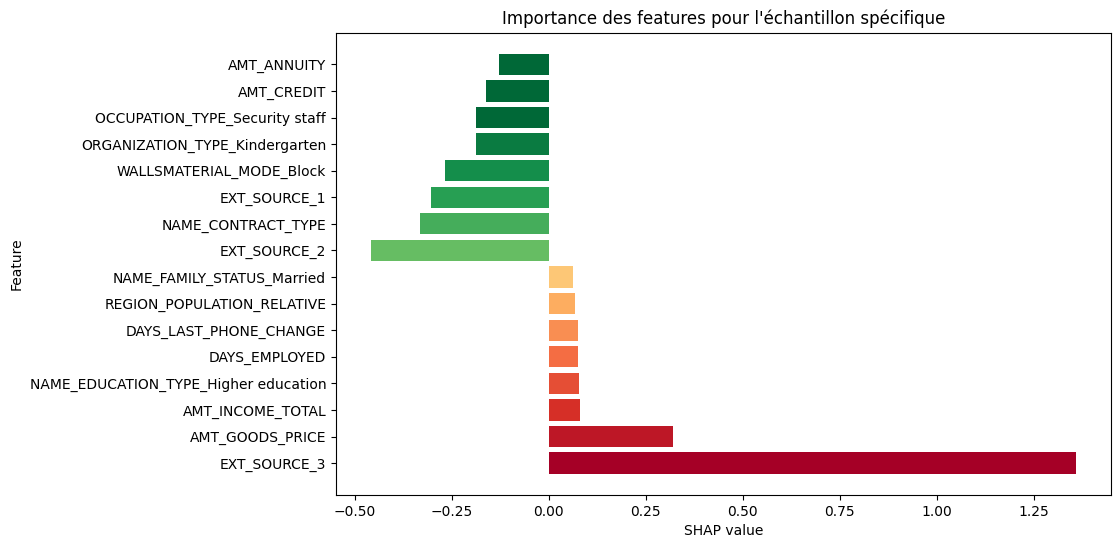

True value : 0
CPU times: user 495 ms, sys: 79.7 ms, total: 575 ms
Wall time: 614 ms


In [ ]:
%%time
from matplotlib.cm import RdYlGn
# Obtenez les noms des caractéristiques
feature_names = list(x_new.columns)

# Index de l'échantillon spécifique que vous souhaitez tracer
sample_index = 10

# Valeurs SHAP pour l'échantillon spécifique
sample_shap_values = shap_values[1][sample_index, :] #shap_values[1][0] array indique une valeur pour chacune de features
#(indique la contribution d'une feature specifique à la predicition de la classe 1)

# Créer un DataFrame avec les valeurs SHAP et les noms des caractéristiques
df_shap = pd.DataFrame({'feature': feature_names, 'SHAP value': sample_shap_values})

# Trier les valeurs SHAP par ordre décroissant
df_shap.sort_values('SHAP value', ascending=False, inplace=True)
df_shap = df_shap.nlargest(8, 'SHAP value').append(df_shap.nsmallest(8, 'SHAP value'))
colors = [RdYlGn(0.05*i) for i in range(8)] + [RdYlGn(0.8 + 0.04*i) for i in range(8)]

# Afficher le graphique avec les noms des caractéristiques
plt.figure(figsize=(10, 6))
plt.barh(y=df_shap['feature'], width=df_shap['SHAP value'],color=colors)
plt.xlabel('SHAP value')
plt.ylabel('Feature')
plt.title('Importance des features pour l\'échantillon spécifique')
plt.show()

print(f"True value : { Ytrain.iloc[sample_index] }")

illustre l'impact des différentes features sur la prédiction de la classe 0 pour un client spécifique.

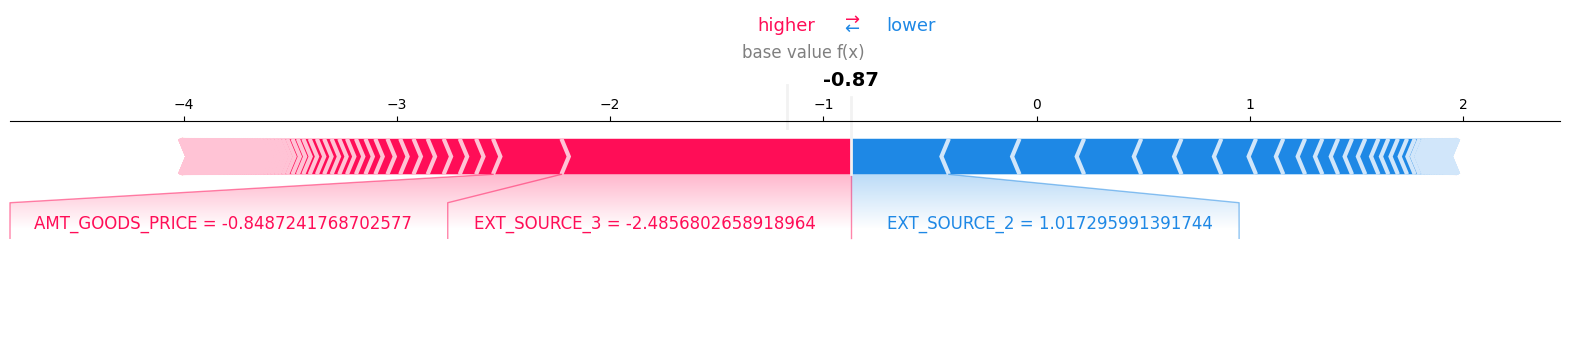

True value : 0


In [ ]:
sample_index = 10
feature_names = list(x_new.columns)

# Valeurs SHAP pour l'échantillon spécifique
sample_shap_values = shap_values[1][sample_index, :]

# Afficher le graphique avec les noms des caractéristiques

shap.force_plot(explainer.expected_value[1], sample_shap_values, x_new.iloc[sample_index, :], feature_names=feature_names, matplotlib=True)
plt.show()
print(f"True value : { Ytrain.iloc[sample_index] }")

 illustre l'impact des différentes features sur la prédiction de la classe 1 pour un client spécifique.



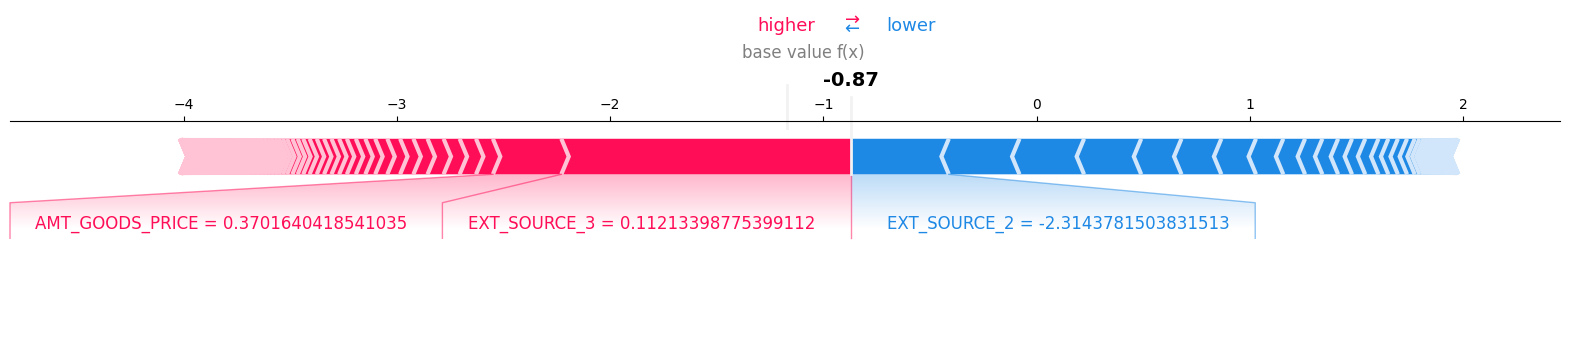

True value : 1


In [ ]:
sample_index = 1

#shap.force_plot(explainer.expected_value[0],shap_values[0][0],x_new.iloc[0,:],matplotlib=True)
# Afficher le graphique avec les noms des caractéristiques

shap.force_plot(explainer.expected_value[1], sample_shap_values, x_new.iloc[sample_index, :], feature_names=feature_names, matplotlib=True)
plt.show()
print(f"True value : { Ytrain.iloc[sample_index] }")

**Importance globale des features**

In [ ]:
feature_importances = pd.DataFrame({'feature': x_new.columns, 'importance': lgbm_shap.feature_importances_})
df = feature_importances.sort_values('importance', ascending = False).reset_index()
df['importance_normalized'] = df['importance'] / df['importance'].sum()

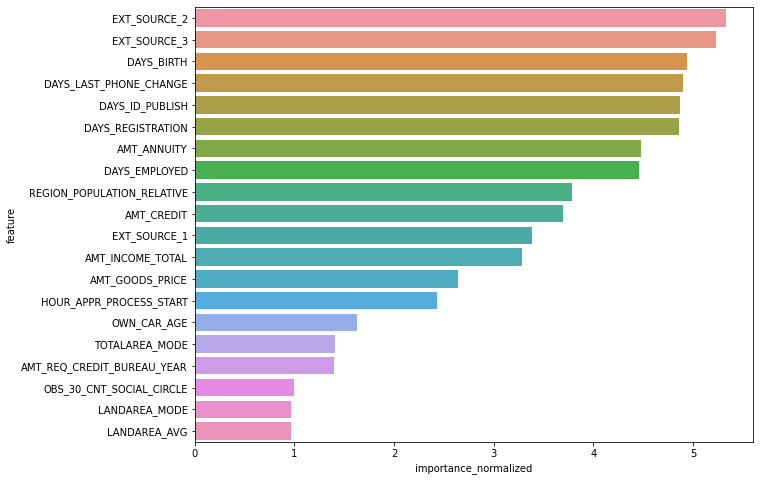

In [ ]:
plt.figure(figsize=[10,8])
sns.barplot(x=(df['importance_normalized']*100).head(20),y=df['feature'].head(20))

In [ ]:
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/projet7/scaler.pkl', 'wb') as f:
    pickle.dump(std, f)

In [ ]:
with open("/content/drive/MyDrive/projet7/explainer_lgbm.pkl", "wb") as explainer_file:
    pickle.dump(explainer, explainer_file)

In [ ]:
with open("/content/drive/MyDrive/projet7/shap_values_lgbm.pkl", "wb") as shap_file:
    pickle.dump(shap_values, shap_file)

In [ ]:
with open('/content/drive/MyDrive/projet7/shap_features.pickle', 'rb') as file:
        features=pickle.load(file)

In [ ]:
#model final selectionne apres optimisation :
with open('/content/drive/MyDrive/projet7/model_lgbm.pickle', 'wb') as file:
        pickle.dump(lgbm_shap, file)

In [ ]:
x_new.to_csv('/content/drive/MyDrive/projet7/x_new.csv')

In [ ]:
Ytrain.to_csv('/content/drive/MyDrive/projet7/Ytrain.csv')

In [ ]:
Xtest.to_csv('/content/drive/MyDrive/projet7/Xtest.csv')

In [ ]:
prediction.to_csv('/content/drive/MyDrive/projet7/df_predict.csv')

par la suite de ce projet, on va concentrer sur le dashboard et les informations utiles à afficher pour le client.